# CM Credits
In this notebook we will use machine learning to predict whether or not clients of a bank will be having banking problems based on information about the clients

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Column description of application data
Here you can find info about the data we will be using

In [18]:
col_desc = pd.read_csv("../src/columns_description.csv",sep=",", encoding='cp1252', index_col=0)
col_desc_app = col_desc[col_desc['Table'] == "application_data"]
col_desc_app = col_desc_app.drop("Table", axis=1)
col_desc_app.set_index("Row", inplace=True)
col_desc_app

Description  \
Row                                                                             
SK_ID_CURR                                           ID of loan in our sample   
TARGET                      Target variable (1 - client with payment diffi...   
NAME_CONTRACT_TYPE                Identification if loan is cash or revolving   
CODE_GENDER                                              Gender of the client   
FLAG_OWN_CAR                                    Flag if the client owns a car   
...                                                                       ...   
AMT_REQ_CREDIT_BUREAU_DAY   Number of enquiries to Credit Bureau about the...   
AMT_REQ_CREDIT_BUREAU_WEEK  Number of enquiries to Credit Bureau about the...   
AMT_REQ_CREDIT_BUREAU_MON   Number of enquiries to Credit Bureau about the...   
AMT_REQ_CREDIT_BUREAU_QRT   Number of enquiries to Credit Bureau about the...   
AMT_REQ_CREDIT_BUREAU_YEAR  Number of enquiries to Credit Bureau about the...   

                           Special  
Row                                 
SK_ID_CURR                     NaN  
TARGET                         NaN  
NAME_CONTRACT_TYPE             NaN  
CODE_GENDER                    NaN  
FLAG_OWN_CAR                   NaN  
...                            ...  
AMT_REQ_CREDIT_BUREAU_DAY      NaN  
AMT_REQ_CREDIT_BUREAU_WEEK     NaN  
AMT_REQ_CREDIT_BUREAU_MON      NaN  
AMT_REQ_CREDIT_BUREAU_QRT      NaN  
AMT_REQ_CREDIT_BUREAU_YEAR     NaN  

[122 rows x 2 columns]

### Get the description of any column

In [22]:
col_desc_app.loc['REG_REGION_NOT_LIVE_REGION']['Description']

"Flag if client's permanent address does not match contact address (1=different, 0=same, at region level)"

## Application Data
This is the data we will be using

In [3]:
app_data = pd.read_csv("../src/application_data.csv",sep=",", encoding='cp1252', index_col=0)
app_data.head()

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002           1         Cash loans           M            N   
100003           0         Cash loans           F            N   
100004           0    Revolving loans           M            Y   
100006           0         Cash loans           F            N   
100007           0         Cash loans           M            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   
100006                   Y             0          135000.0    312682.5   
100007                   Y             0          121500.0    513000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  ... FLAG_DOCUMENT_18  \
SK_ID_CURR                                ...                    
100002          24700.5         351000.0  ...                0   
100003          35698.5        1129500.0  ...                0   
100004           6750.0         135000.0  ...                0   
100006          29686.5         297000.0  ...                0   
100007          21865.5         513000.0  ...                0   

           FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
SK_ID_CURR                                                      
100002                    0                0                0   
100003                    0                0                0   
100004                    0                0                0   
100006                    0                0                0   
100007                    0                0                0   

           AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
SK_ID_CURR                                                         
100002                            0.0                        0.0   
100003                            0.0                        0.0   
100004                            0.0                        0.0   
100006                            NaN                        NaN   
100007                            0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
SK_ID_CURR                                                          
100002                             0.0                        0.0   
100003                             0.0                        0.0   
100004                             0.0                        0.0   
100006                             NaN                        NaN   
100007                             0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
SK_ID_CURR                                                         
100002                            0.0                         1.0  
100003                            0.0                         0.0  
100004                            0.0                         0.0  
100006                            NaN                         NaN  
100007                            0.0                         0.0  

[5 rows x 121 columns]

## Data understanding
Here we try to find features that could be interesting for our model

First we create some bubble charts to see the correlation between certain features and the target feature, the bigger the bubbles the more datapoints correlate the same way.

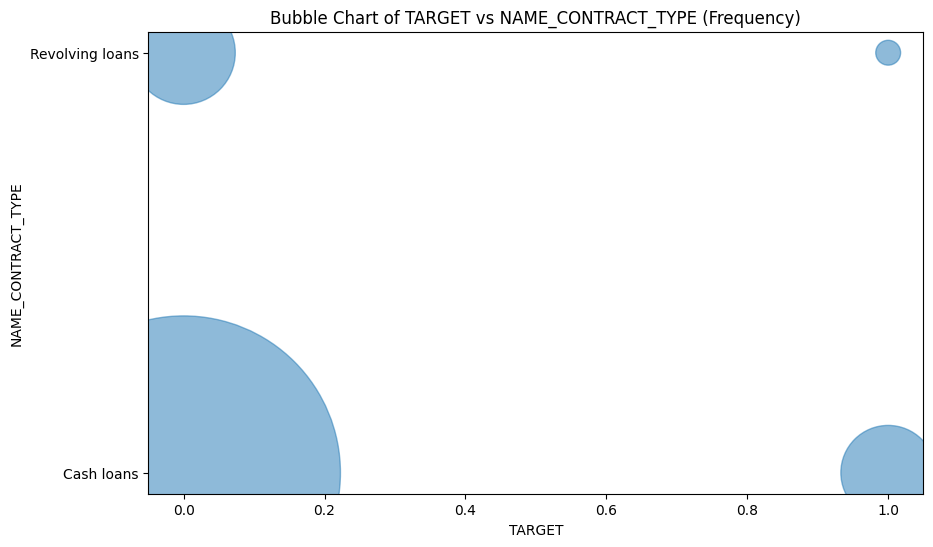

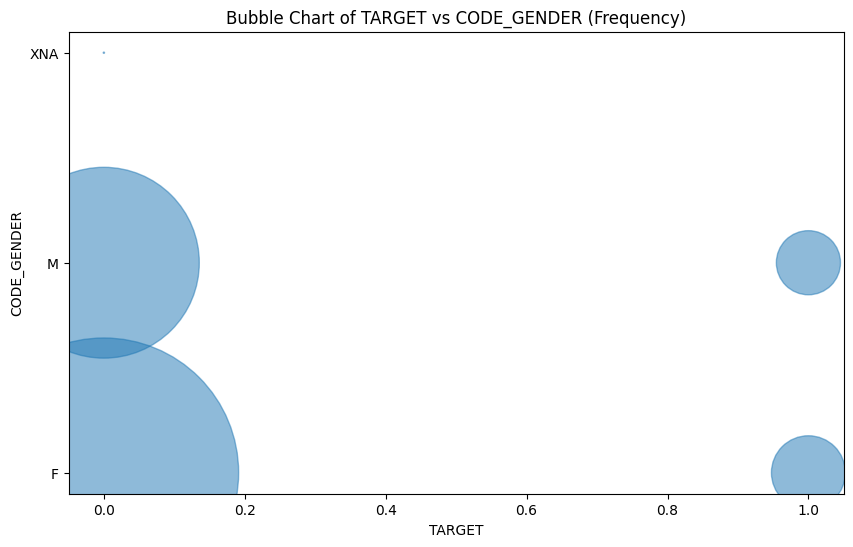

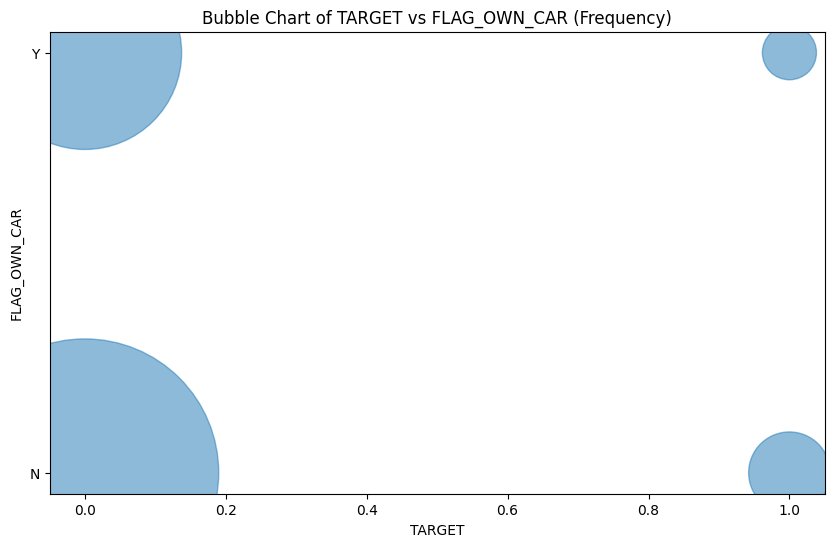

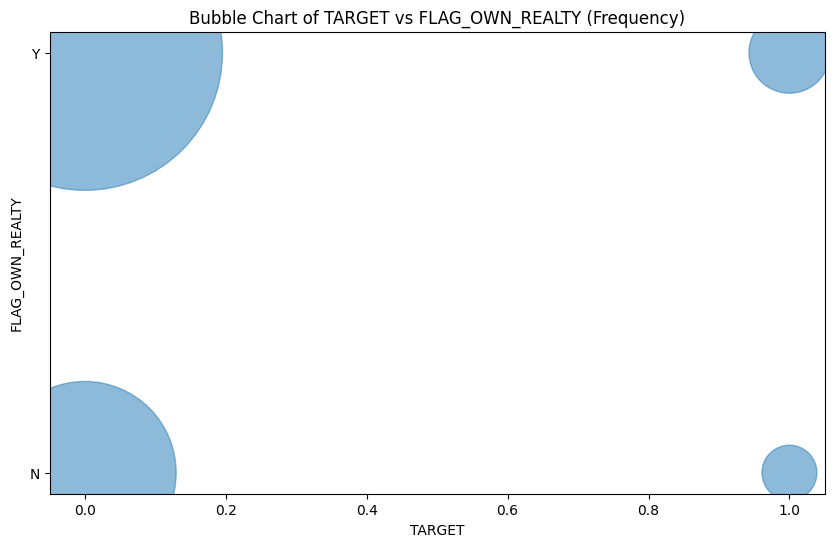

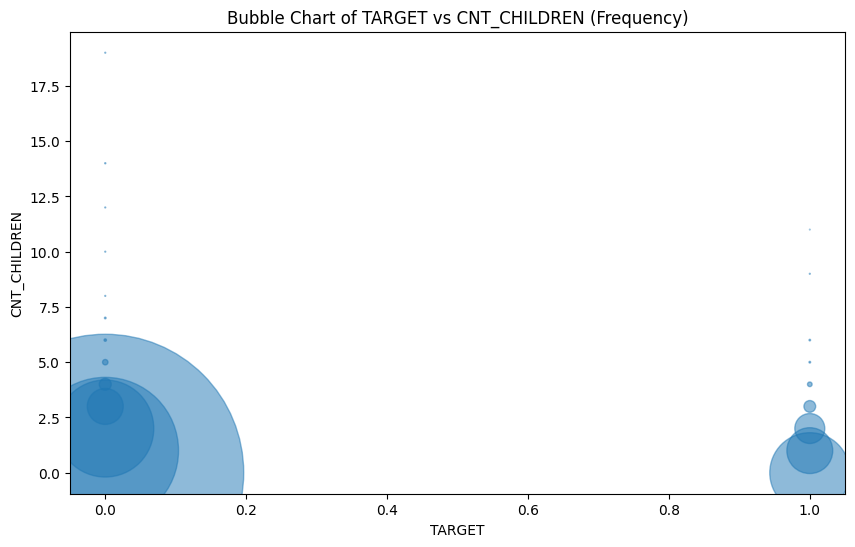

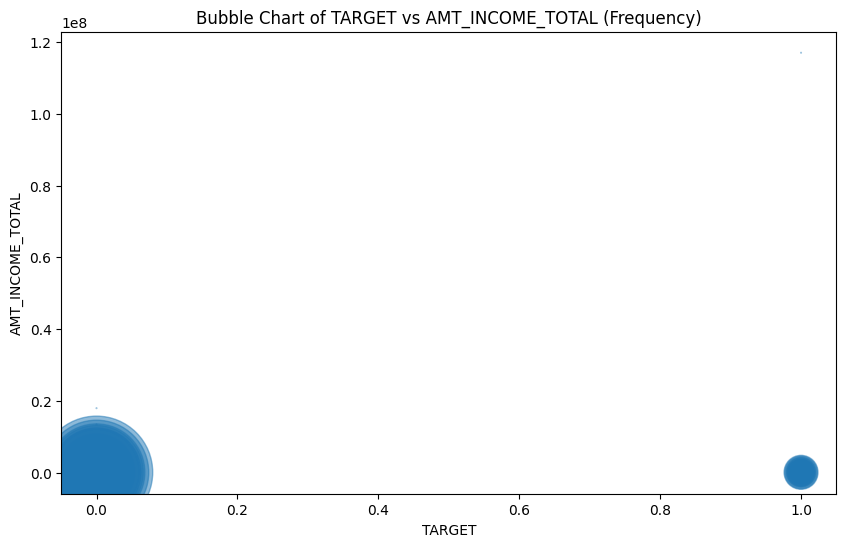

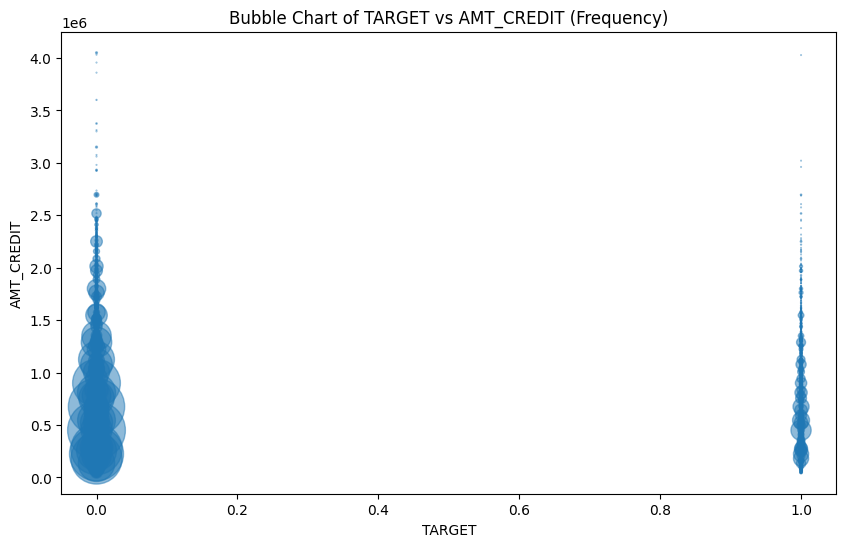

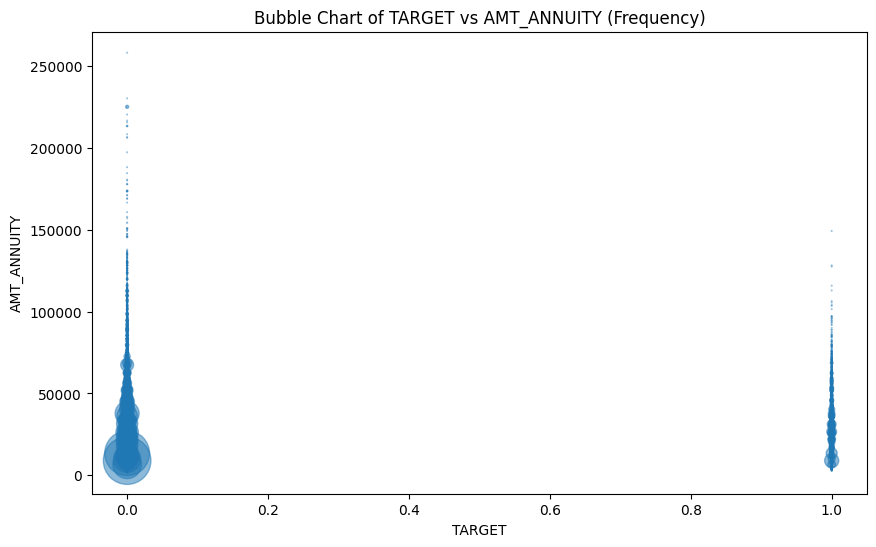

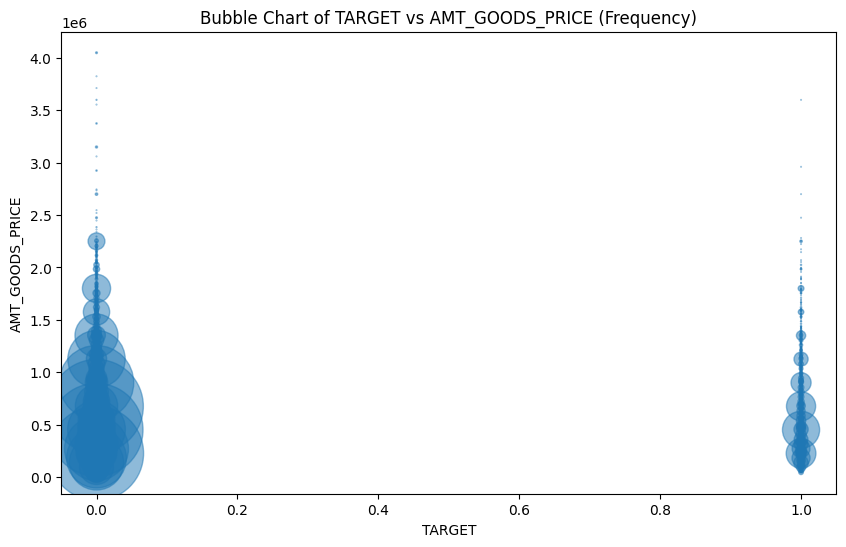

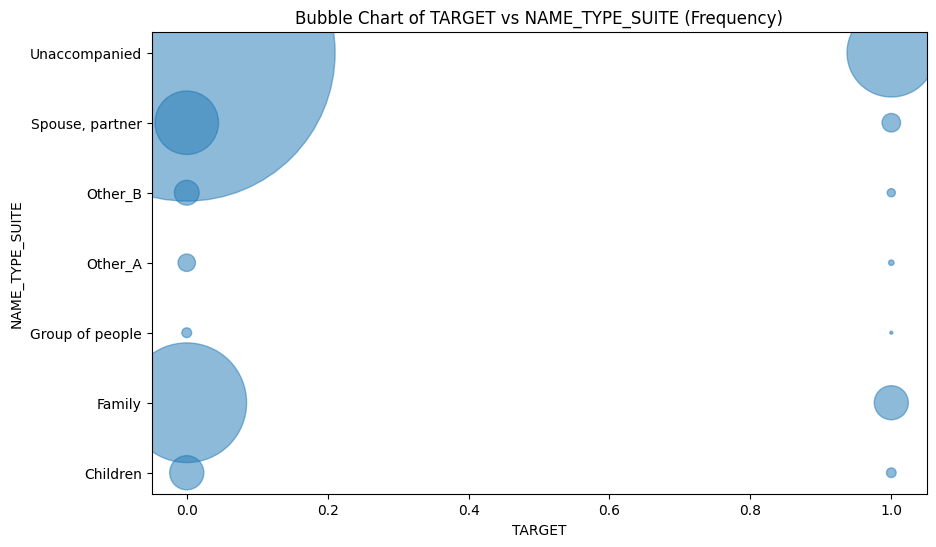

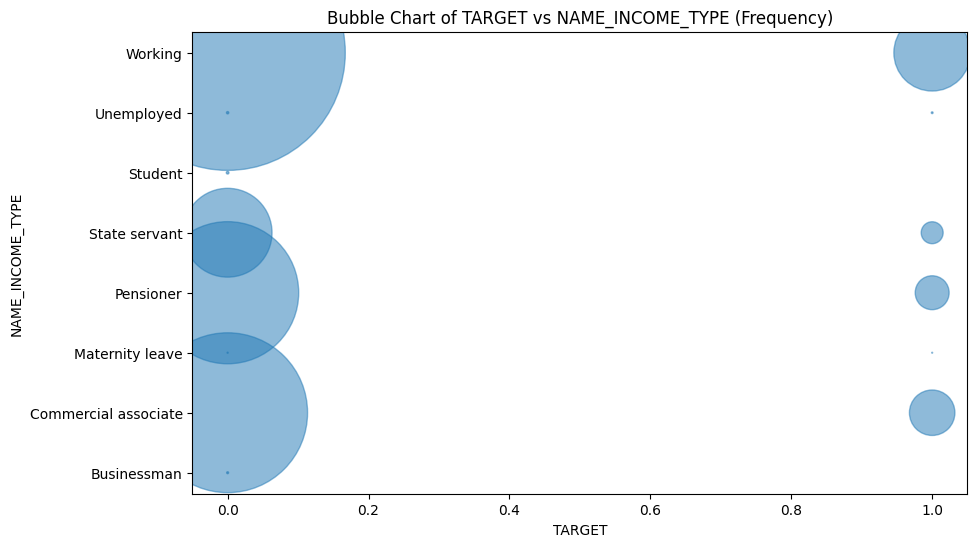

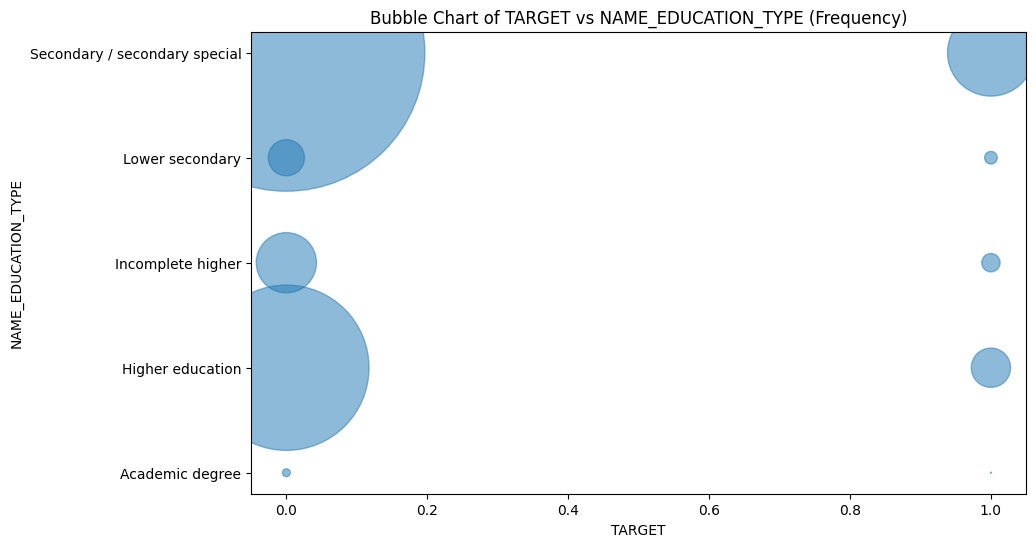

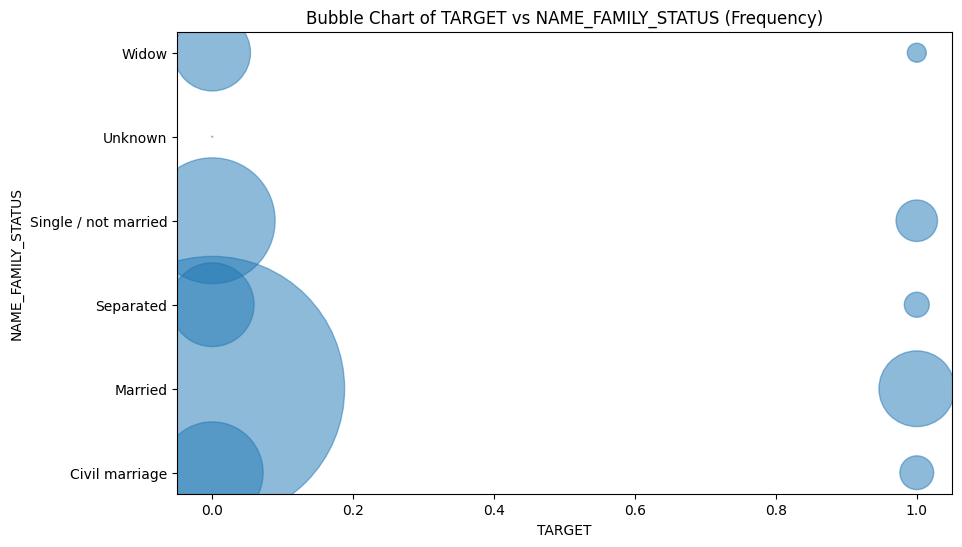

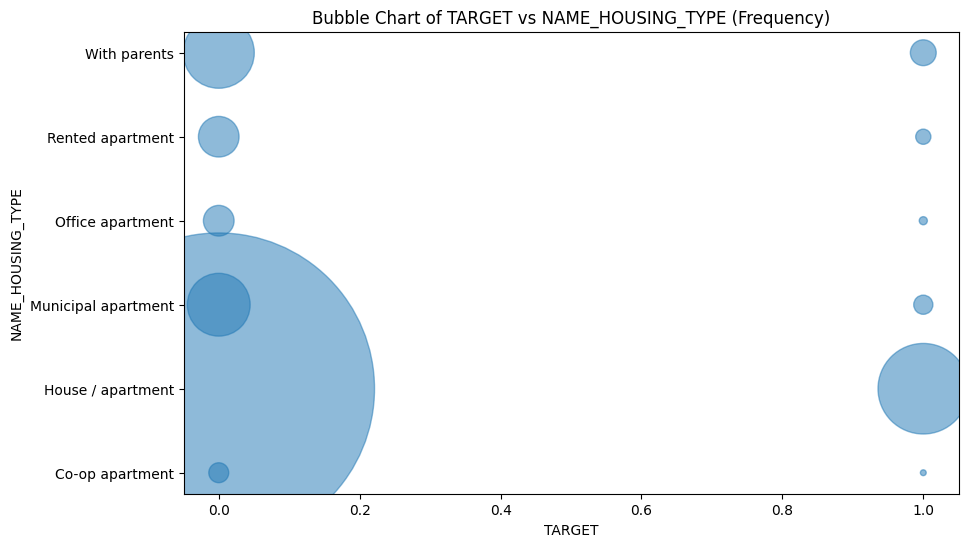

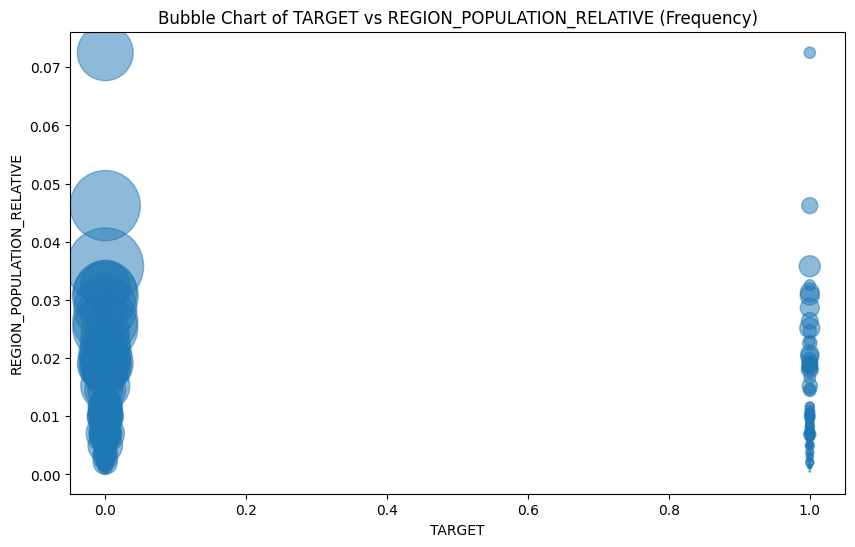

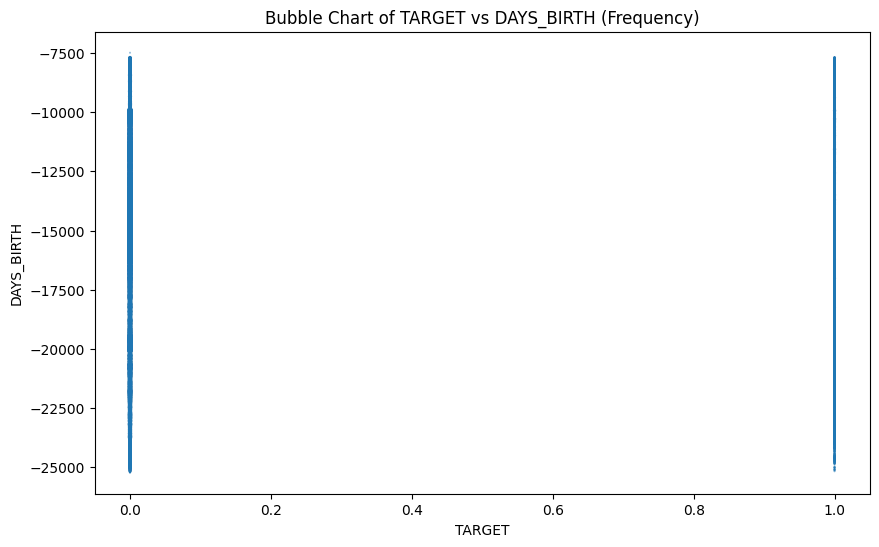

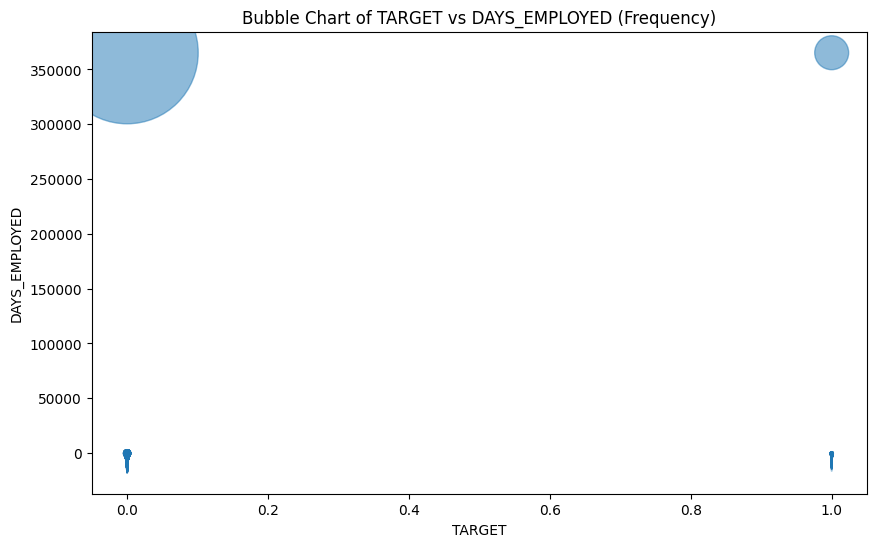

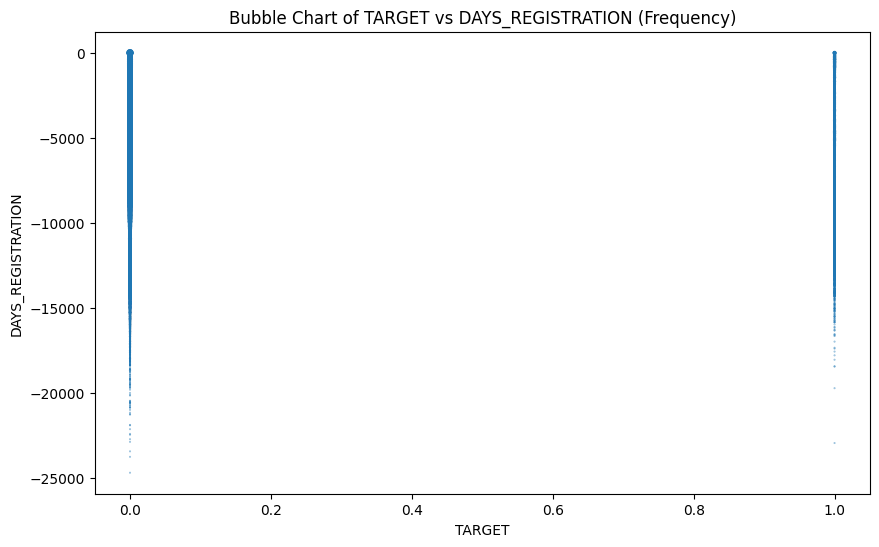

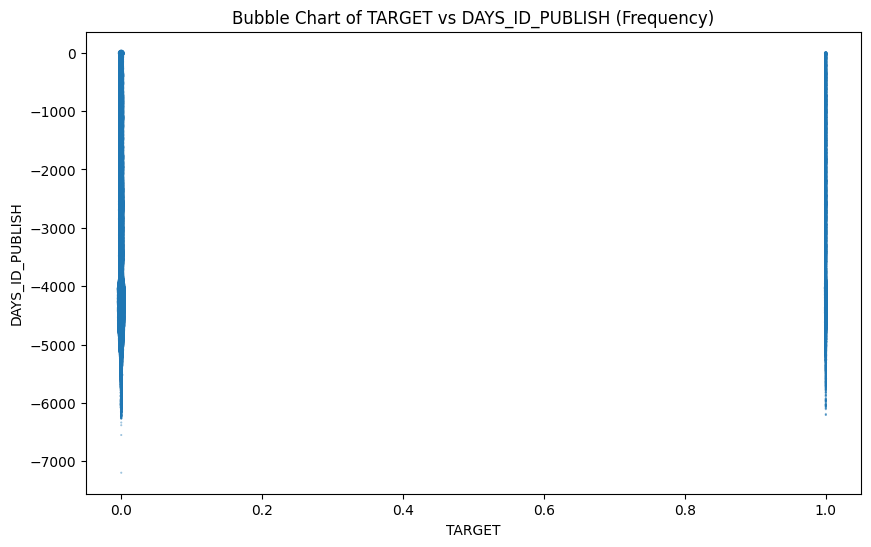

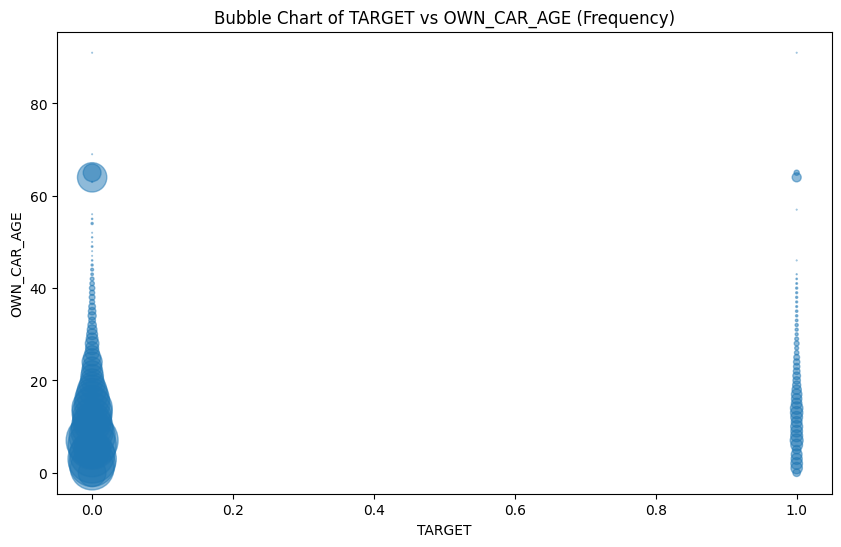

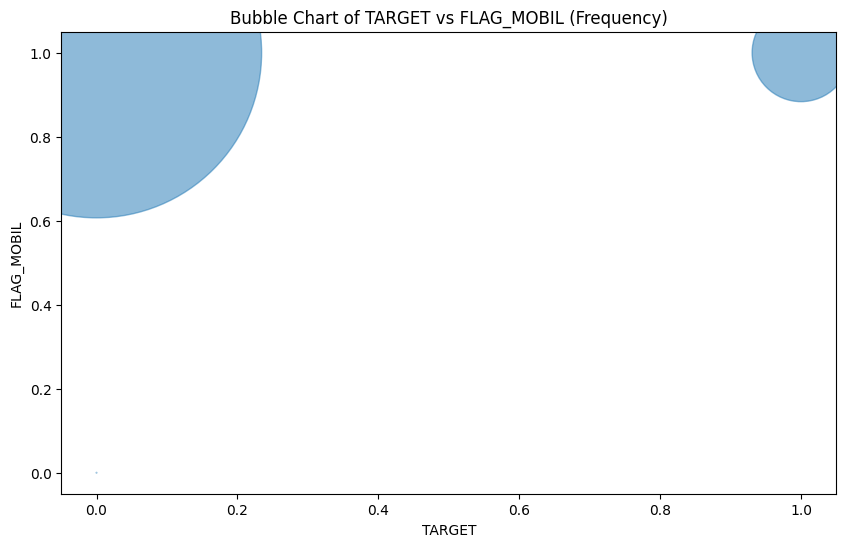

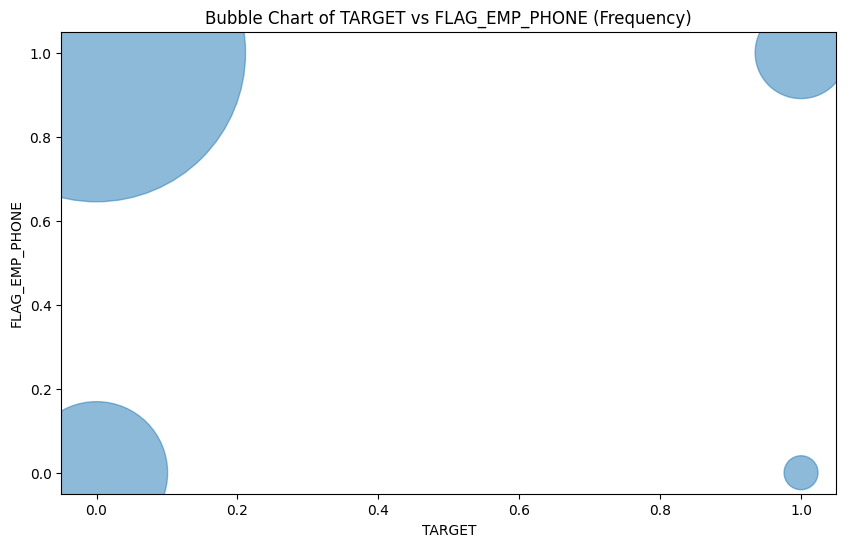

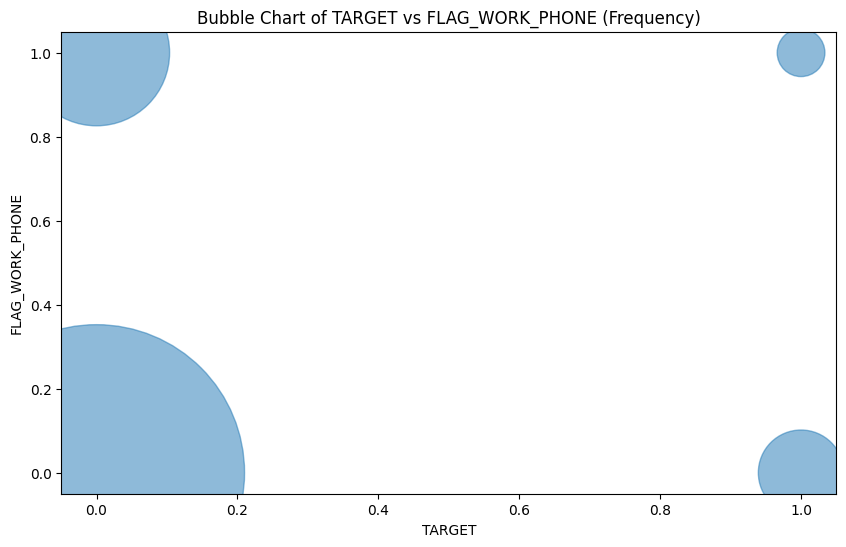

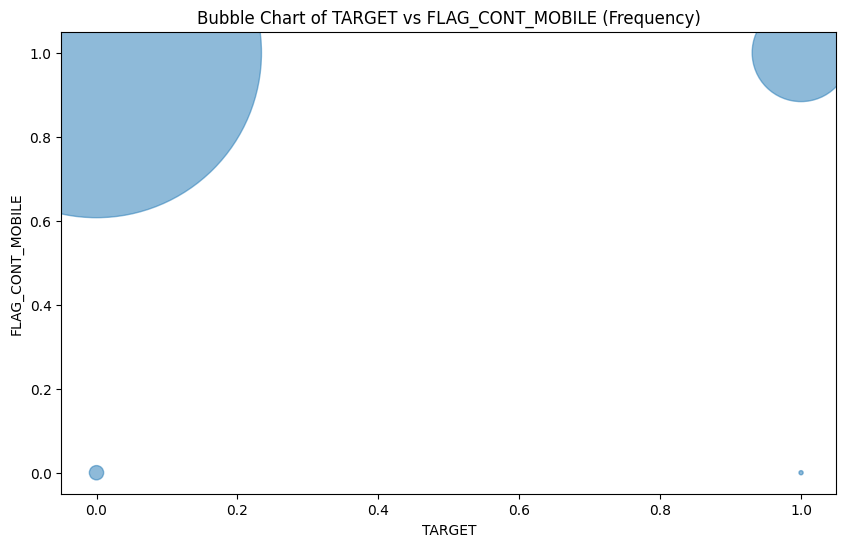

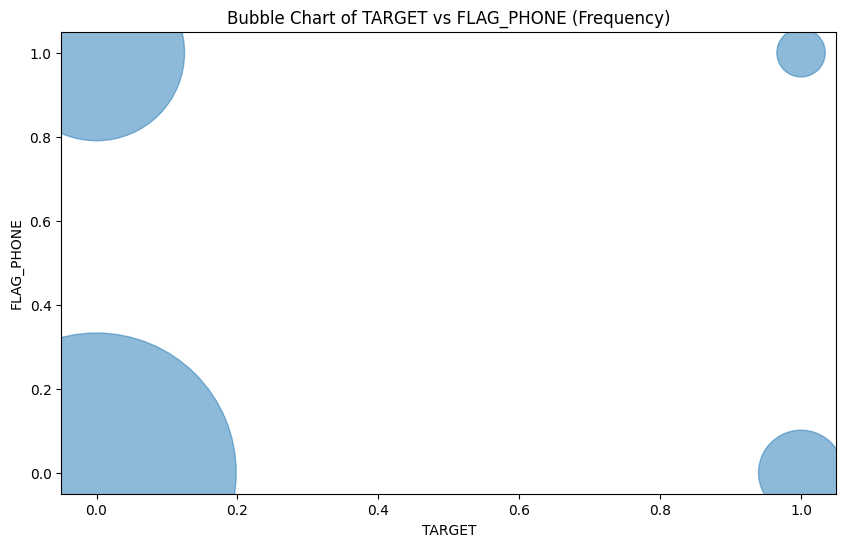

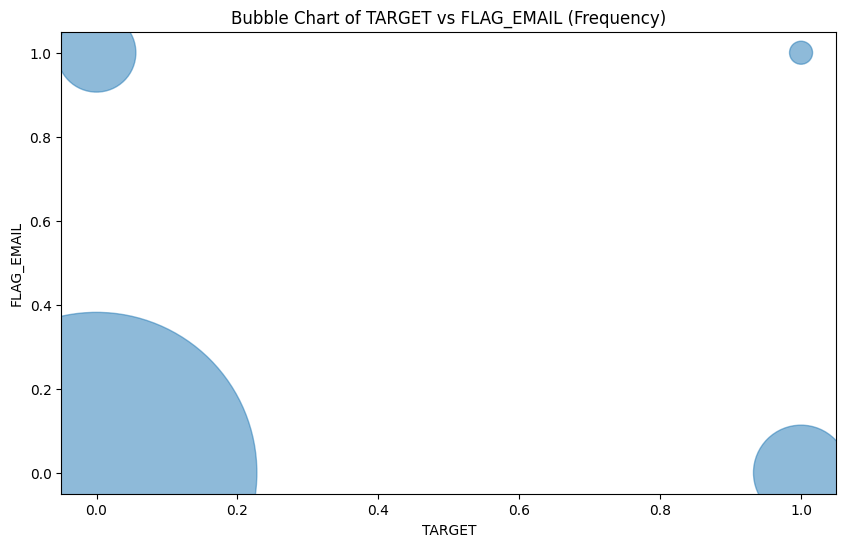

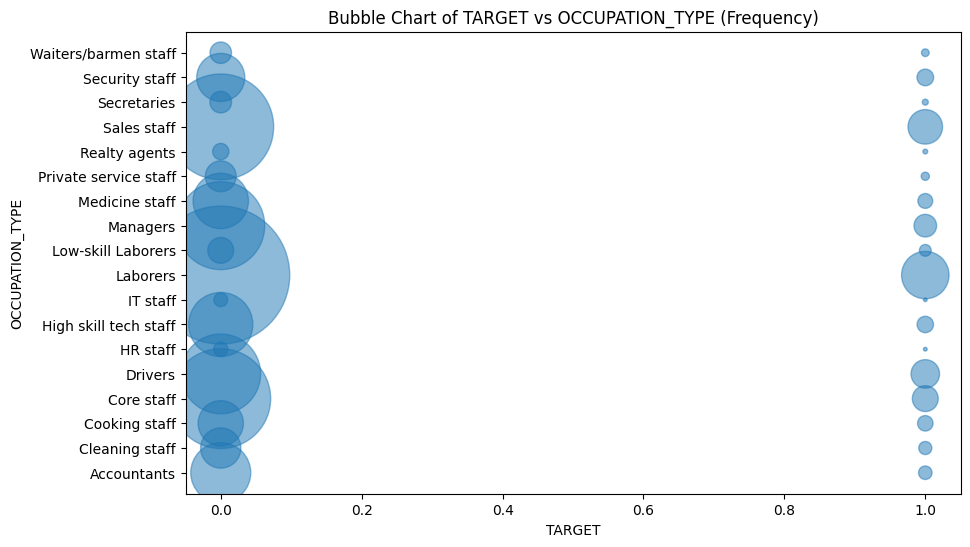

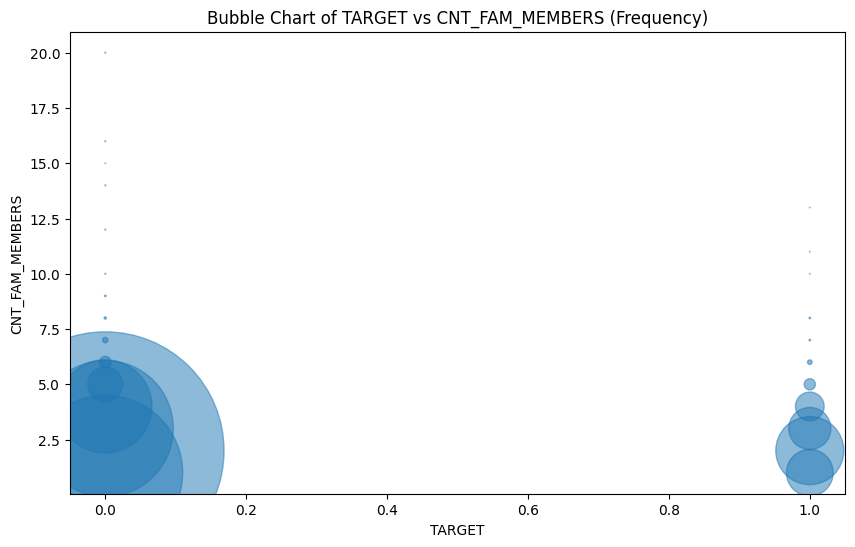

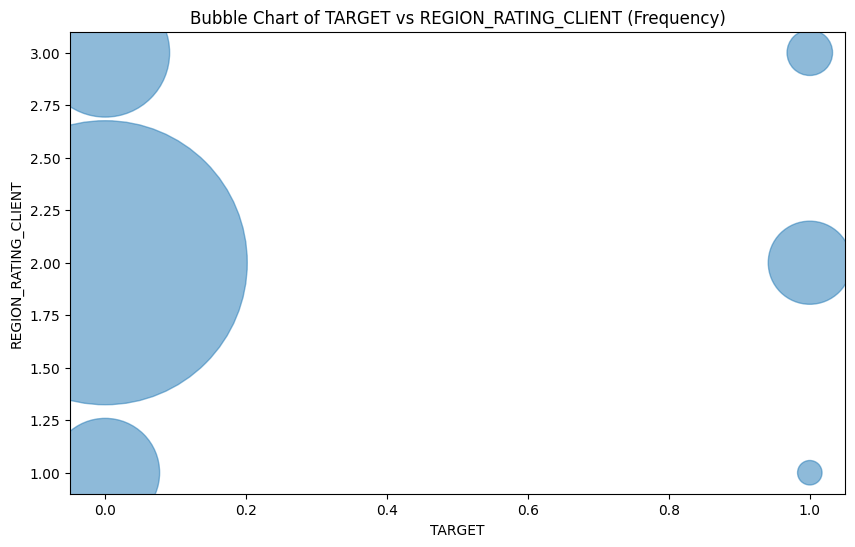

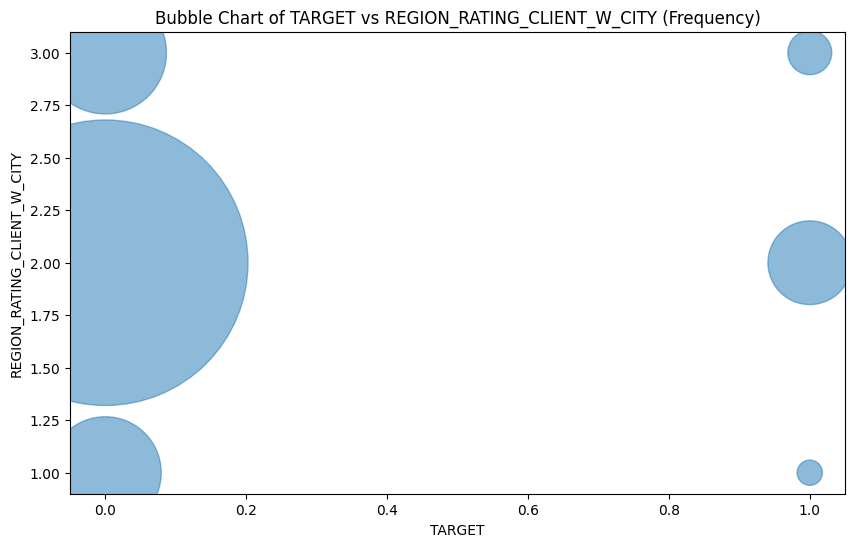

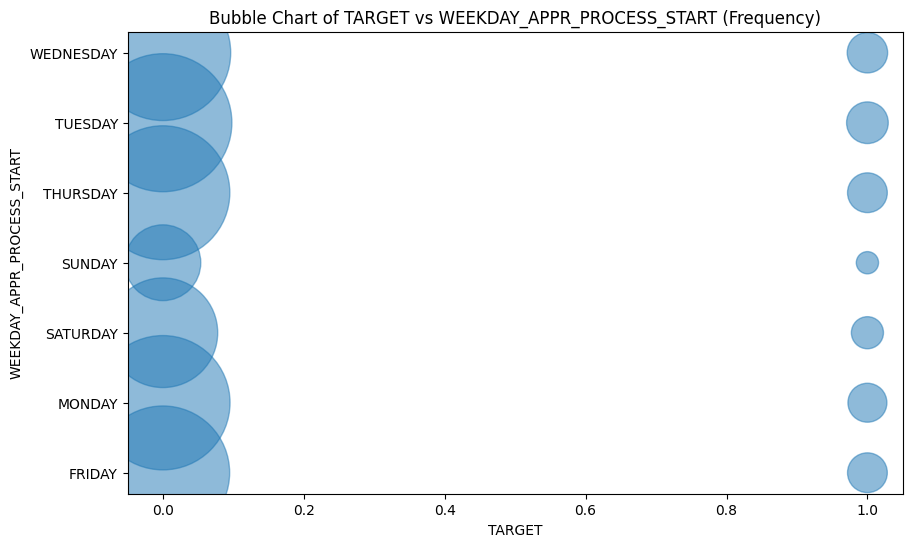

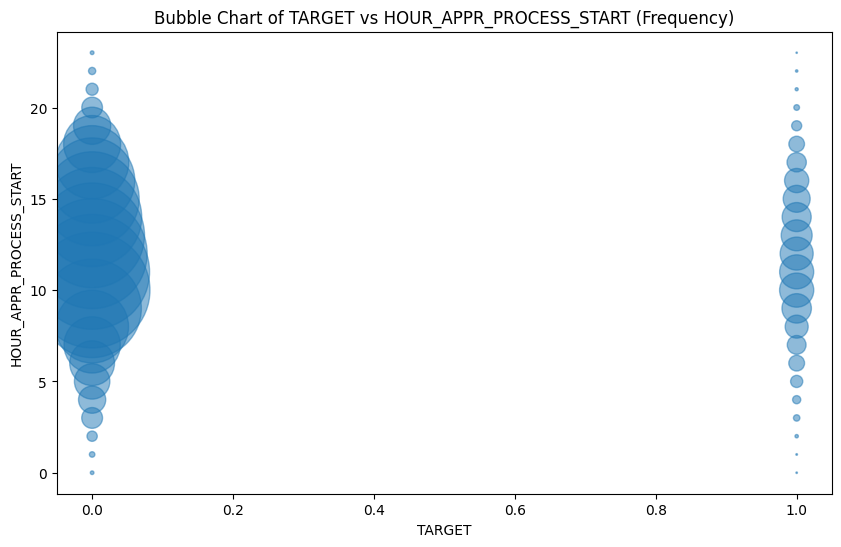

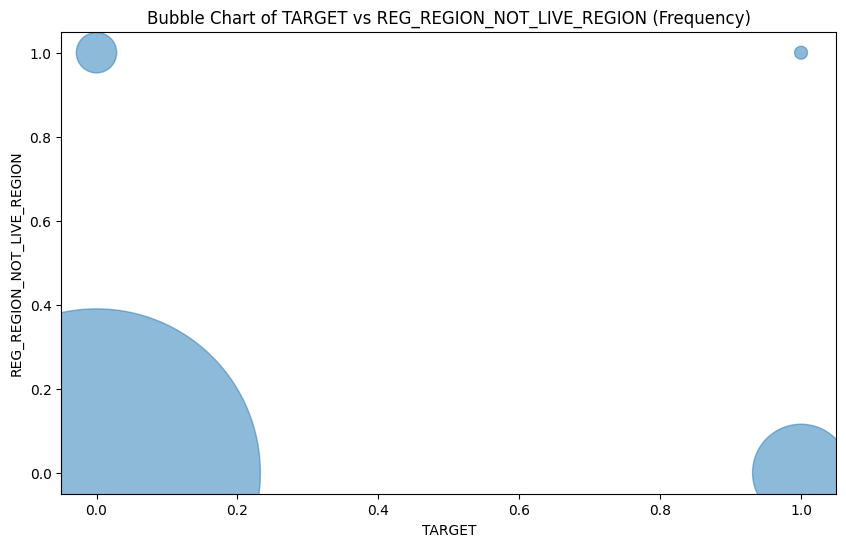

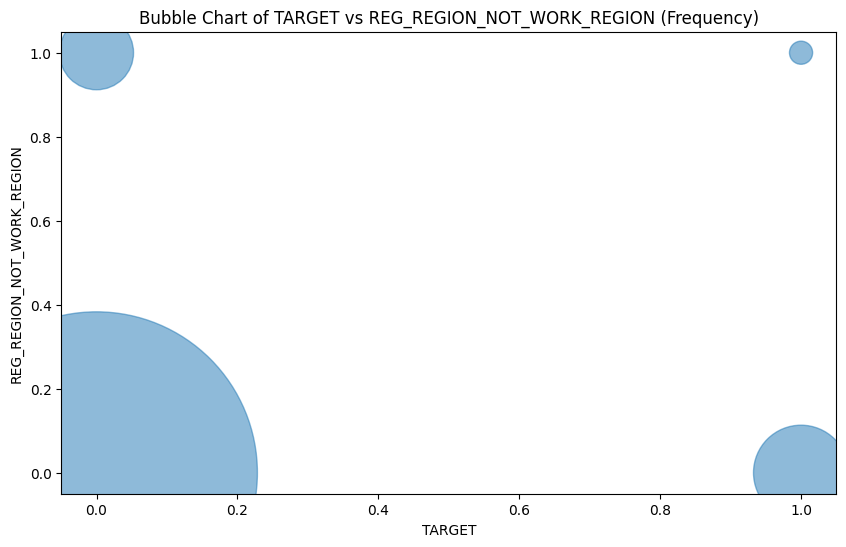

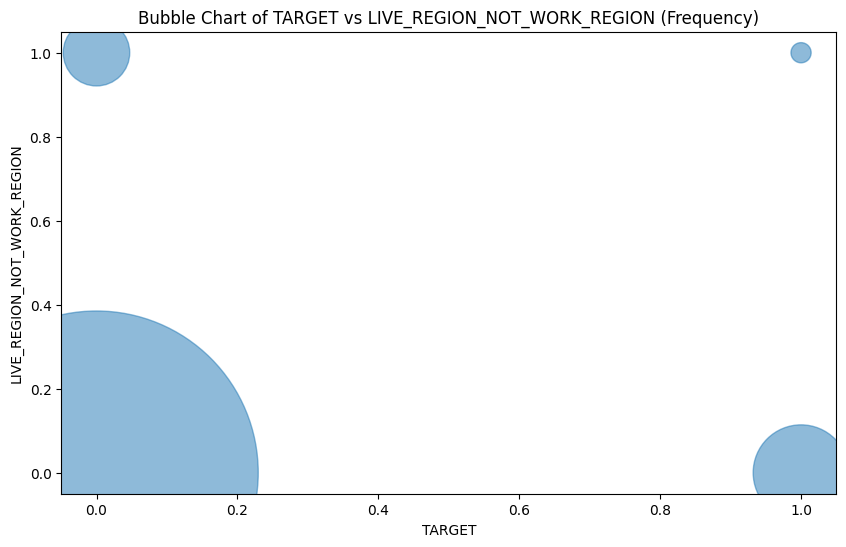

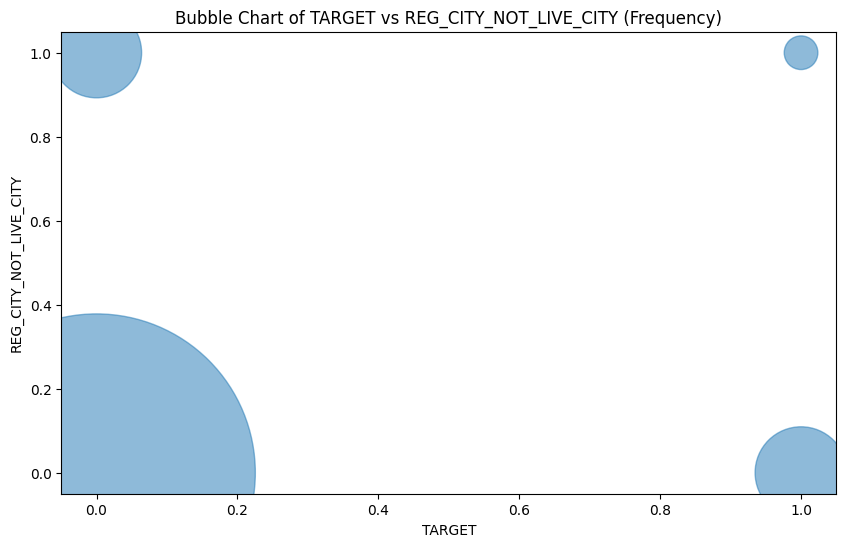

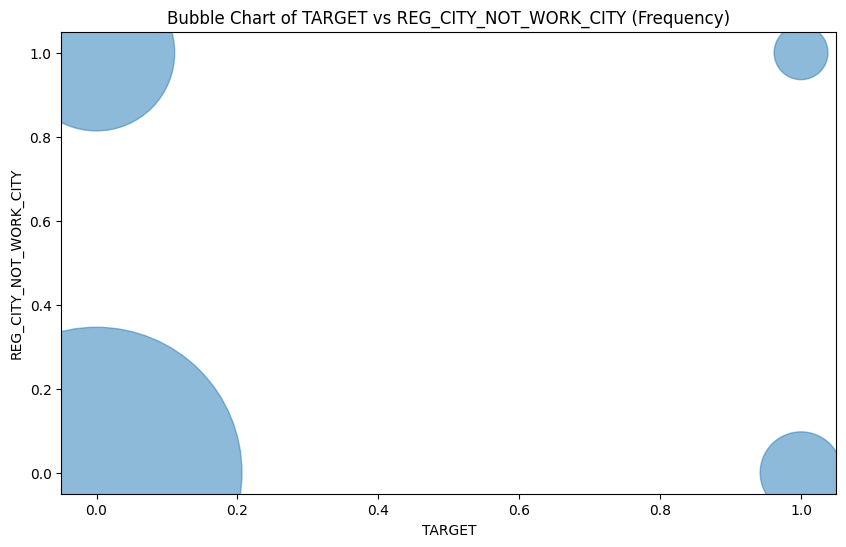

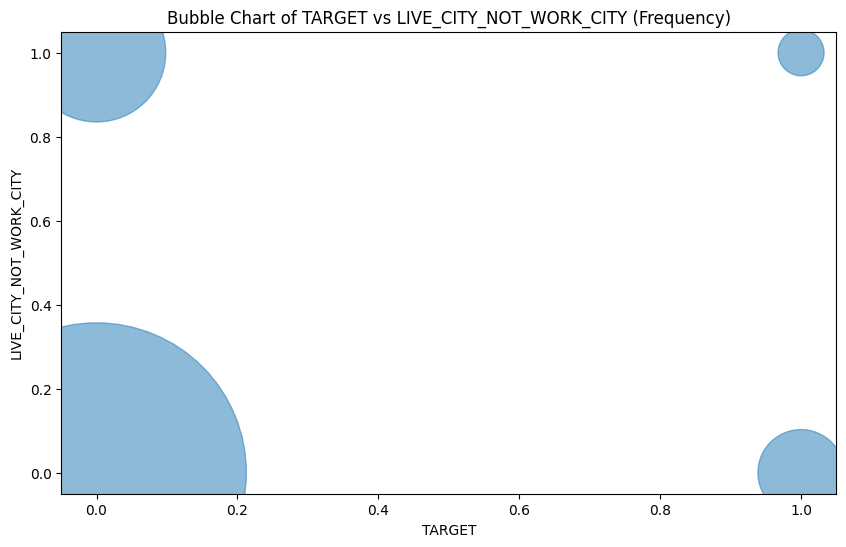

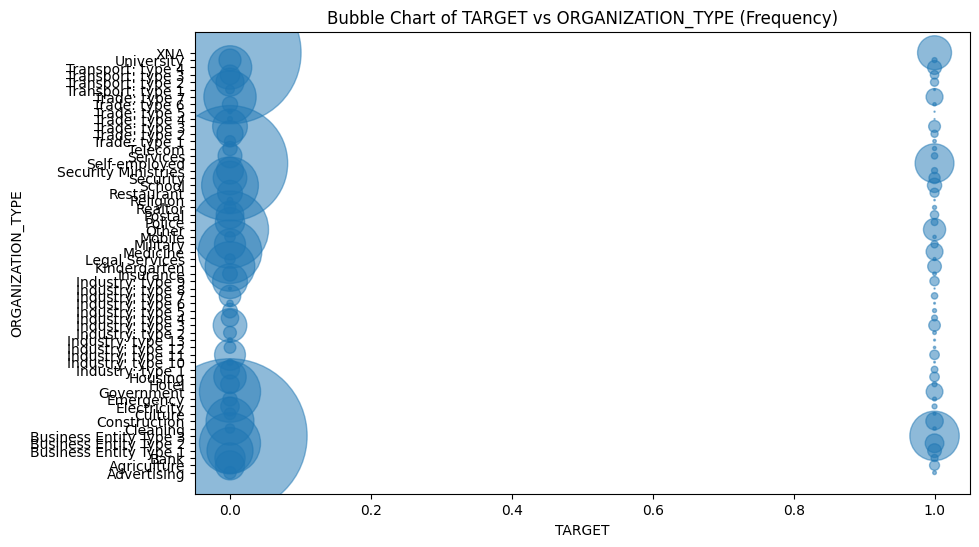

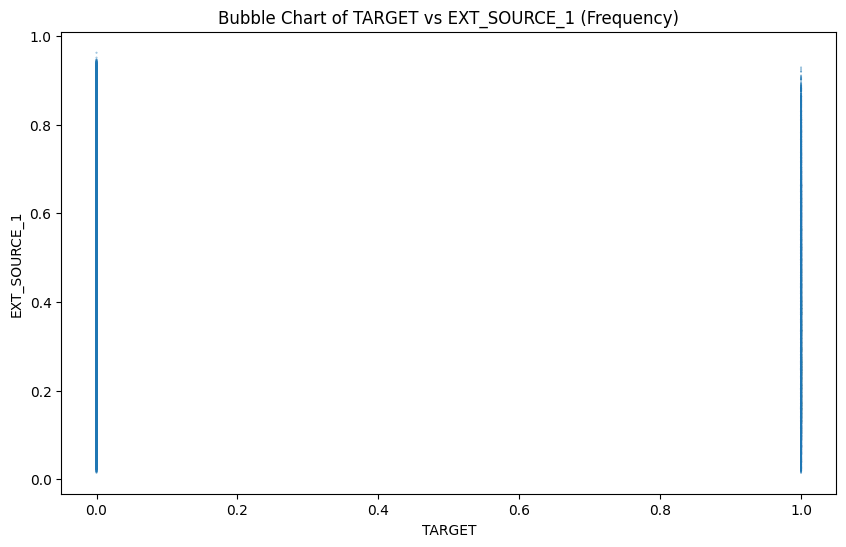

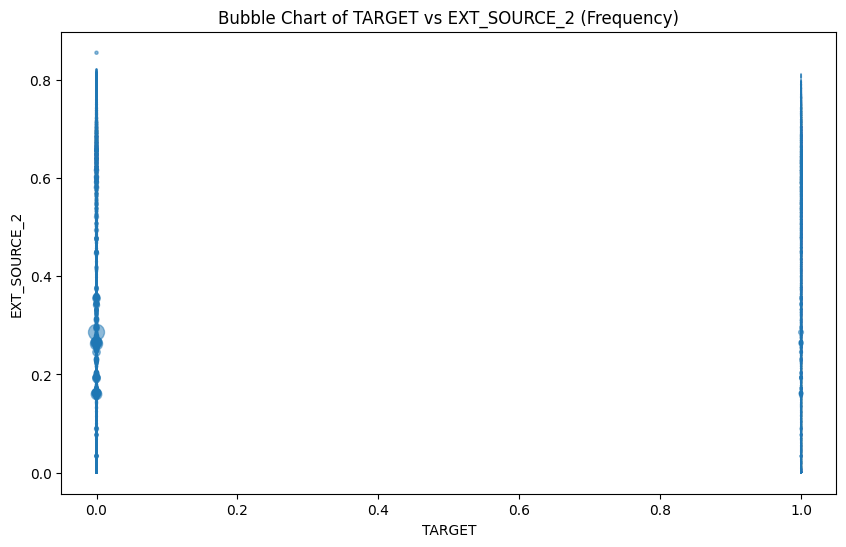

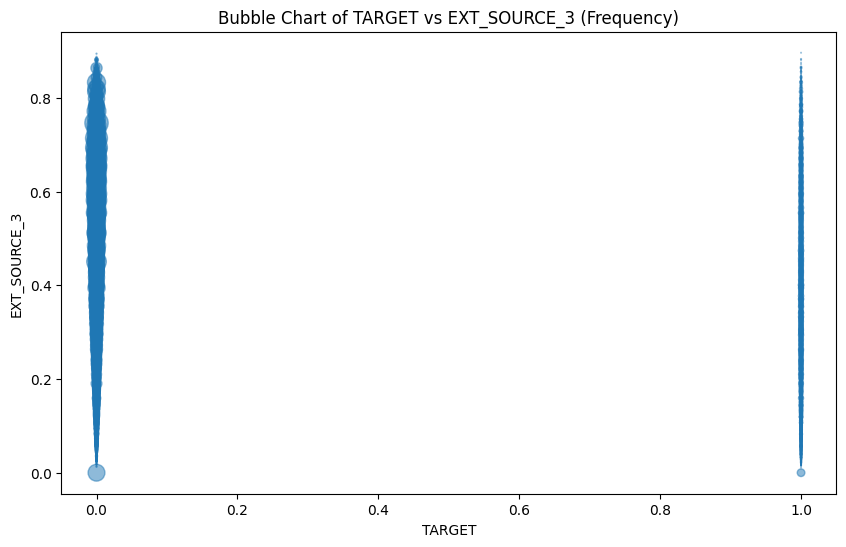

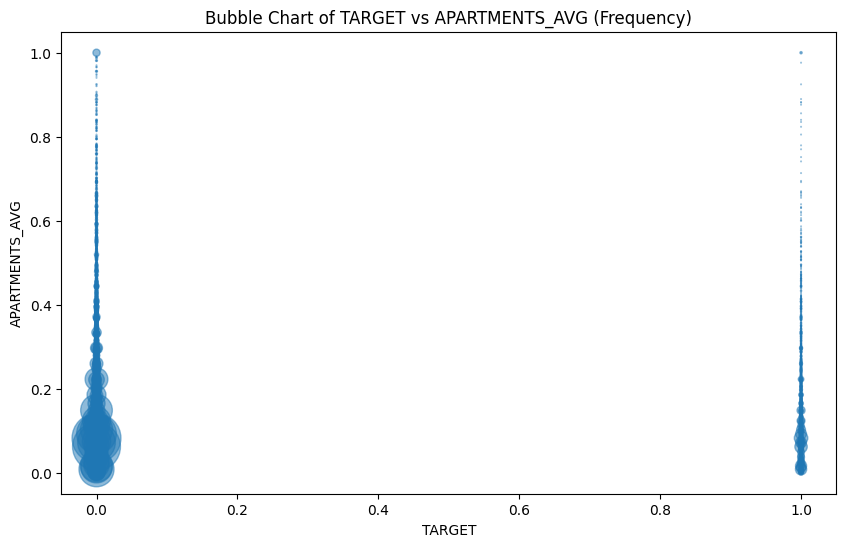

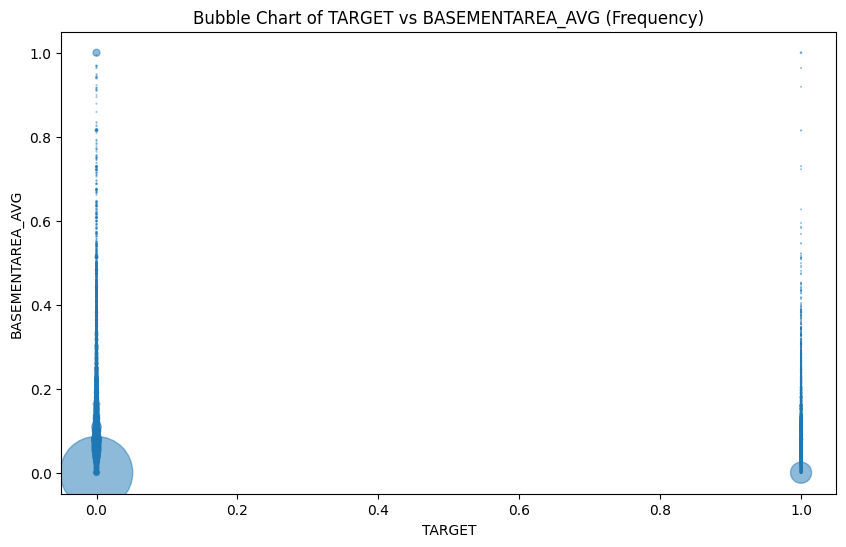

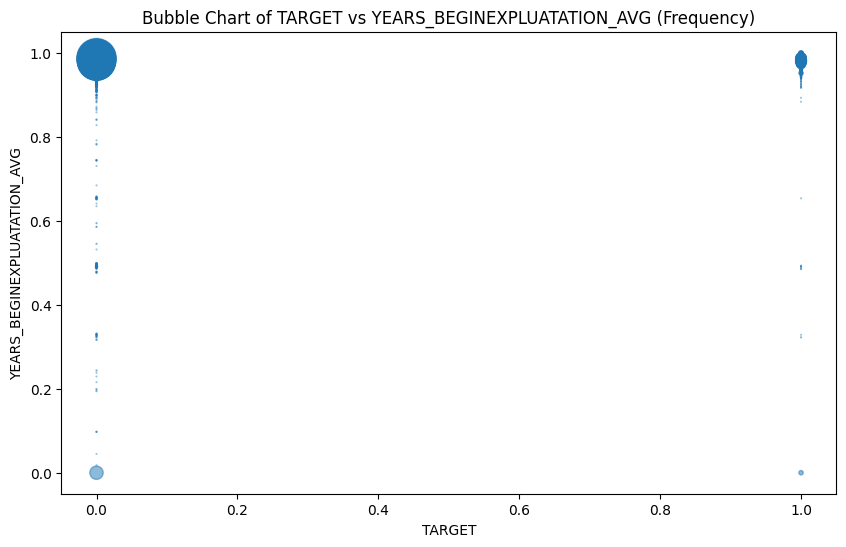

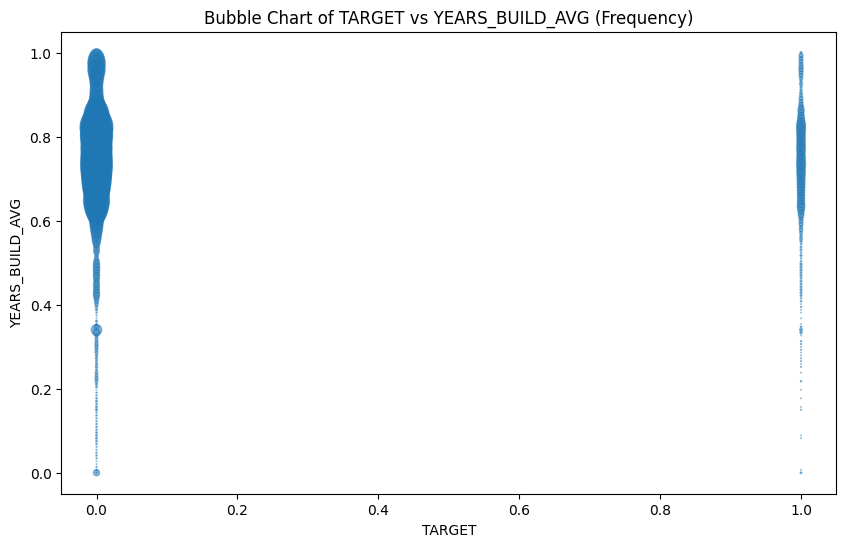

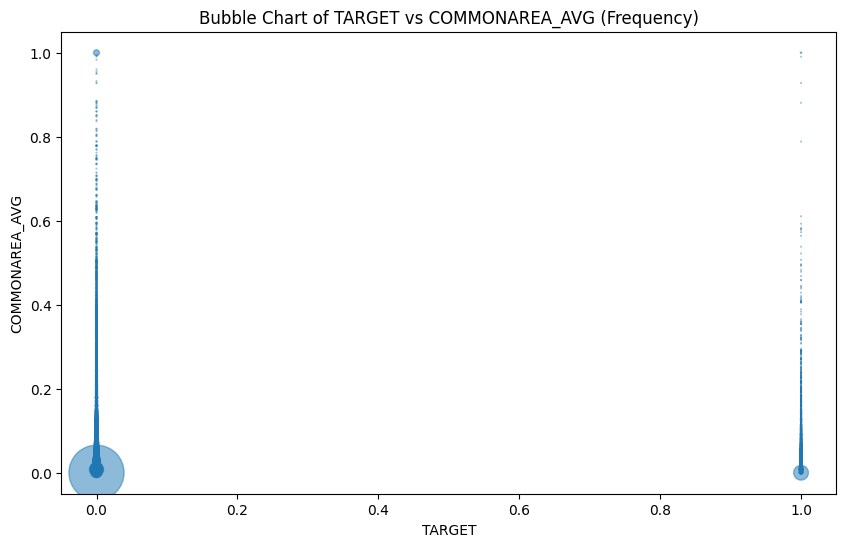

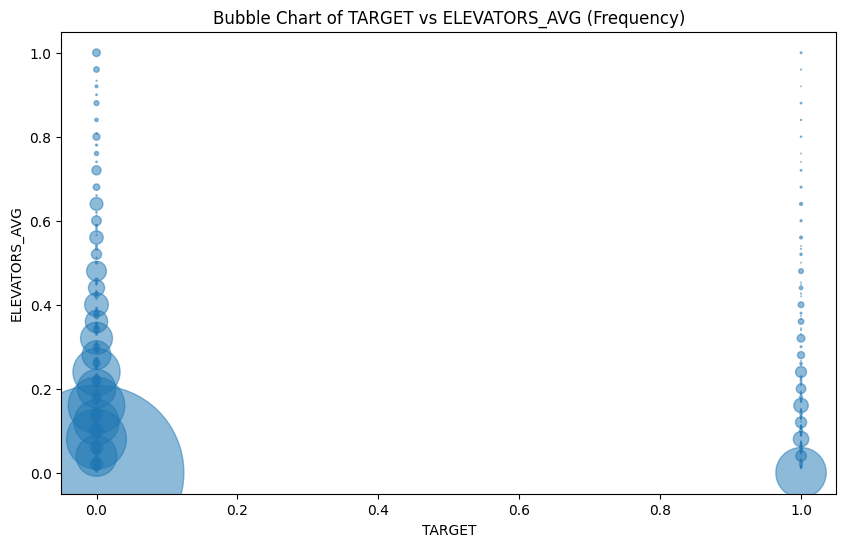

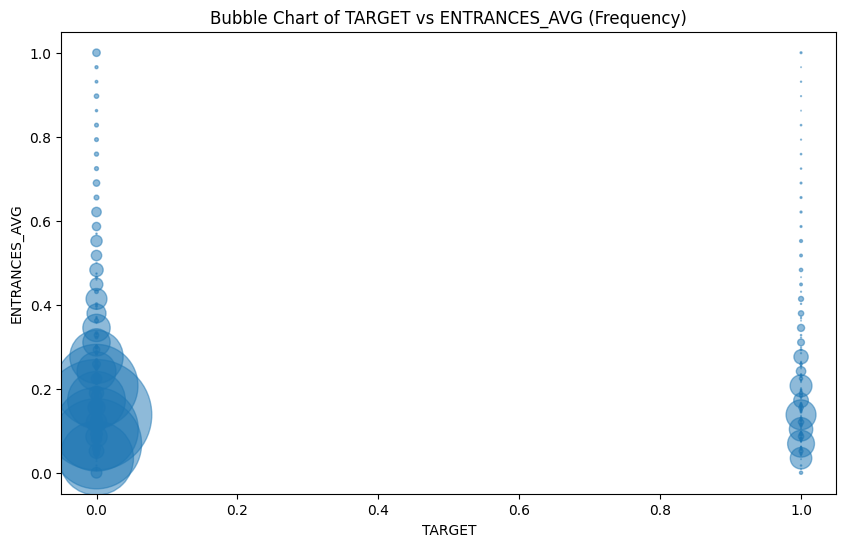

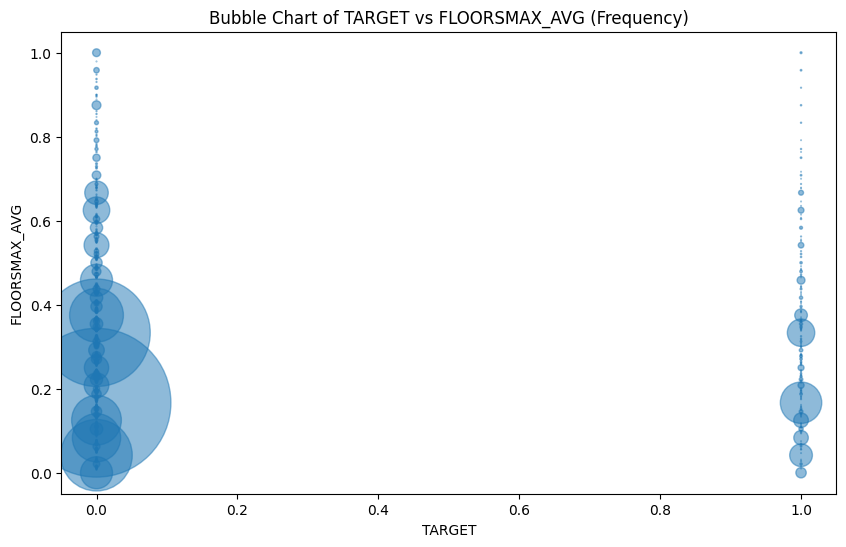

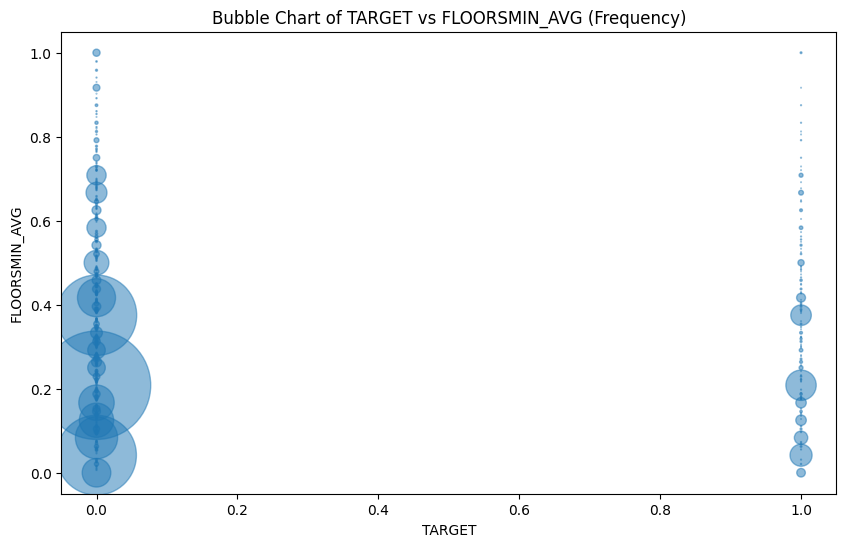

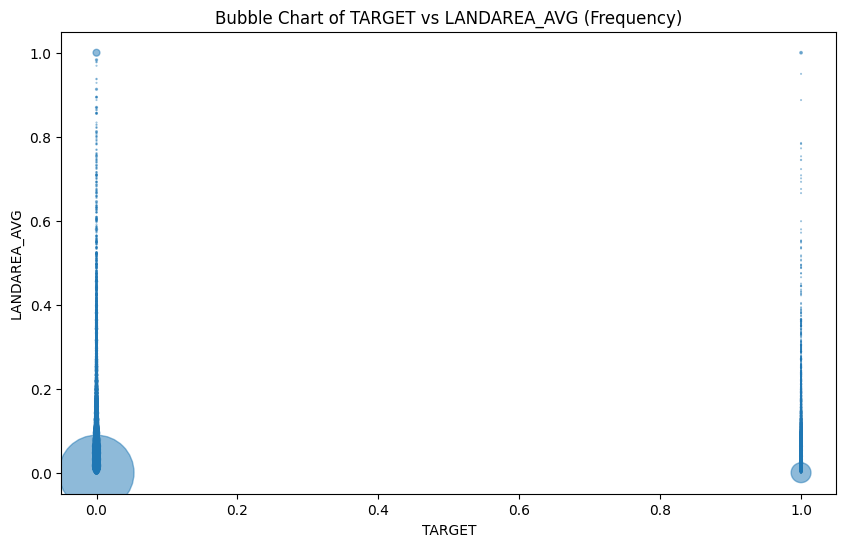

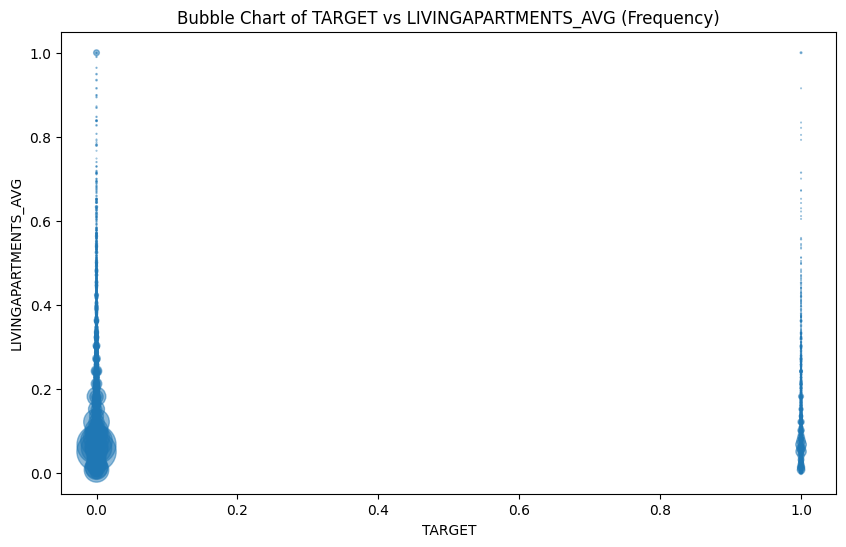

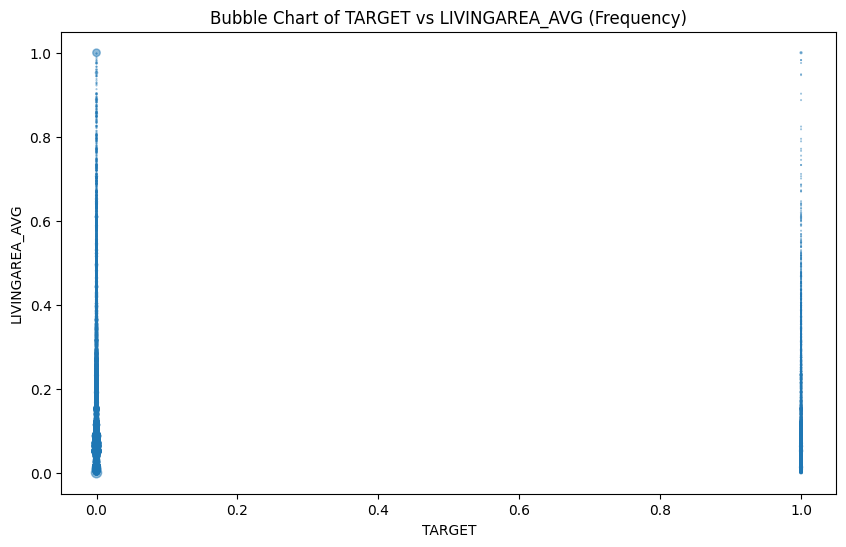

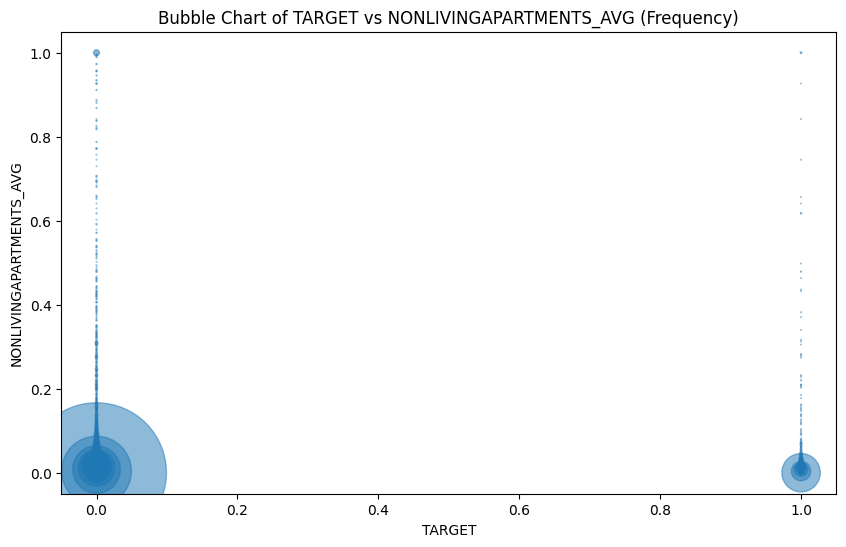

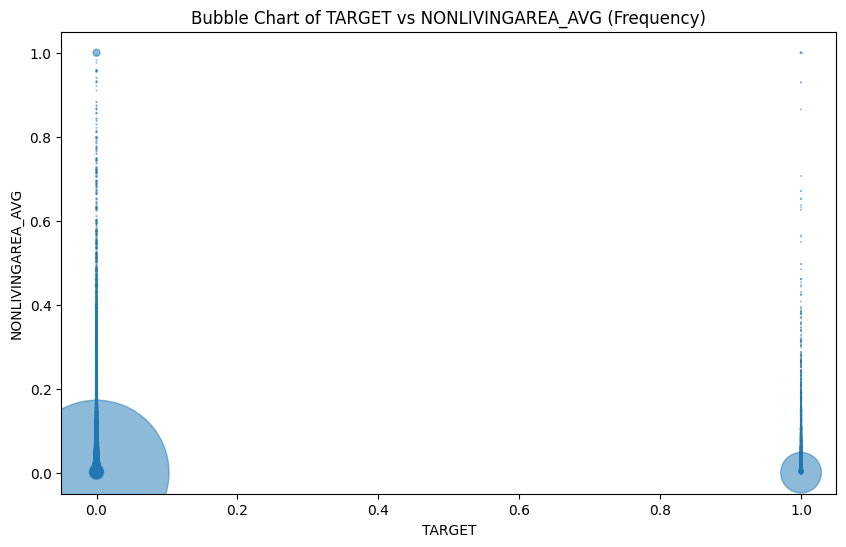

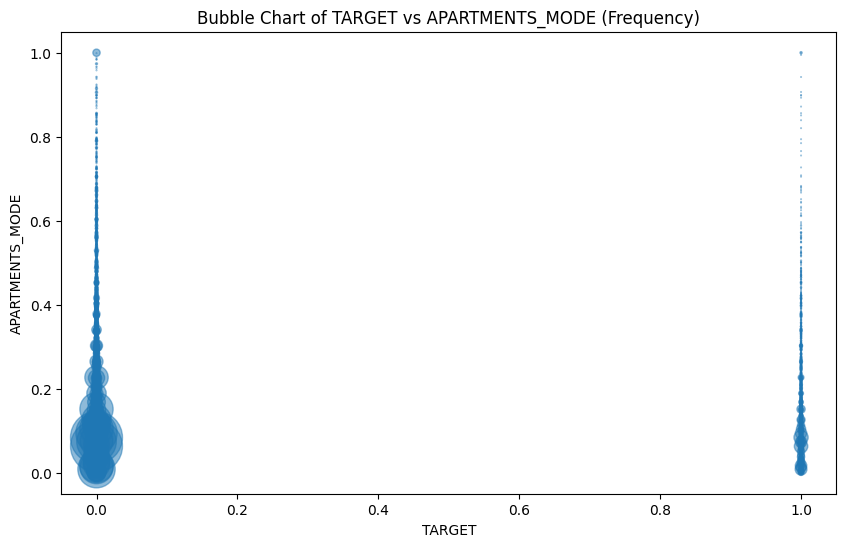

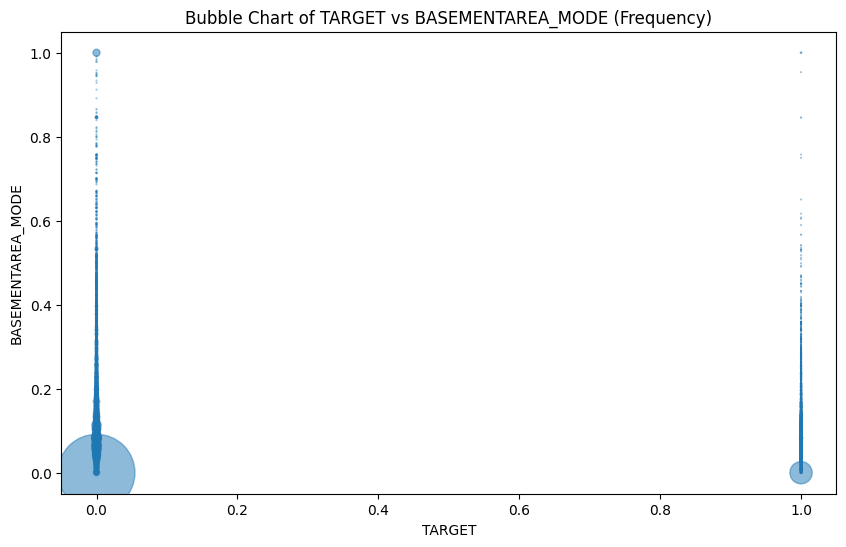

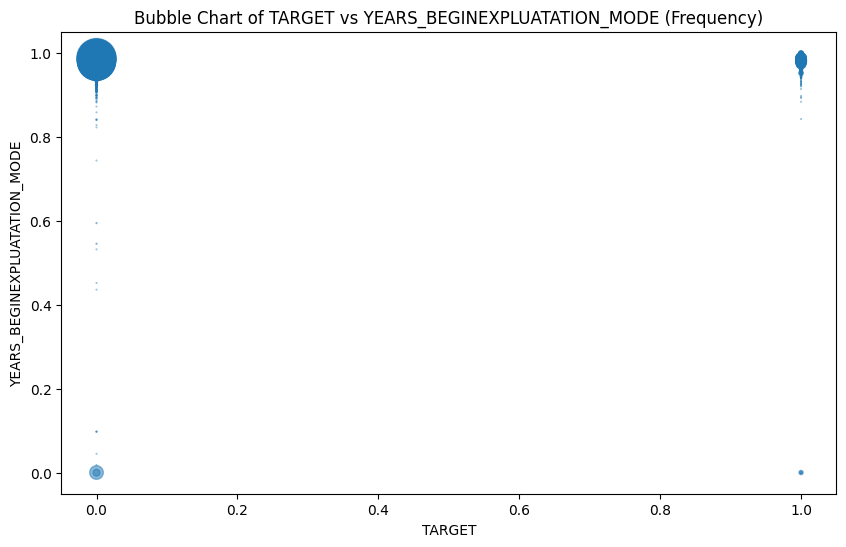

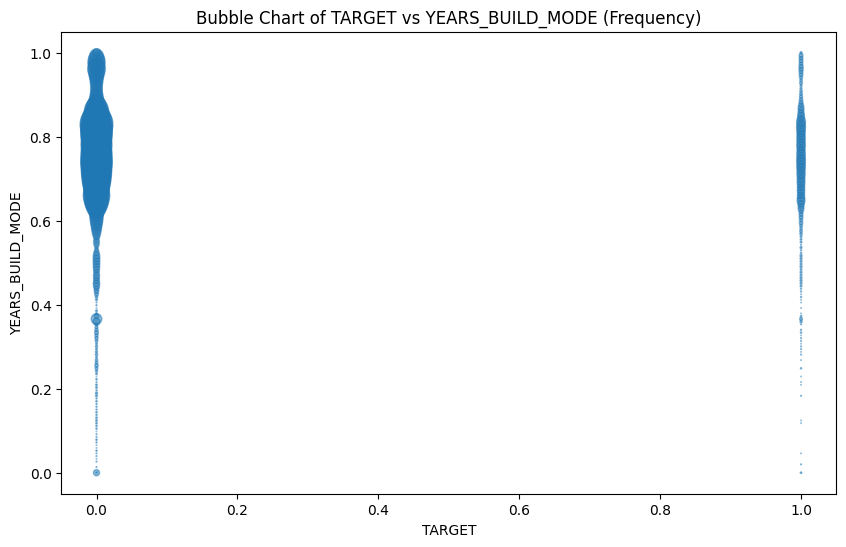

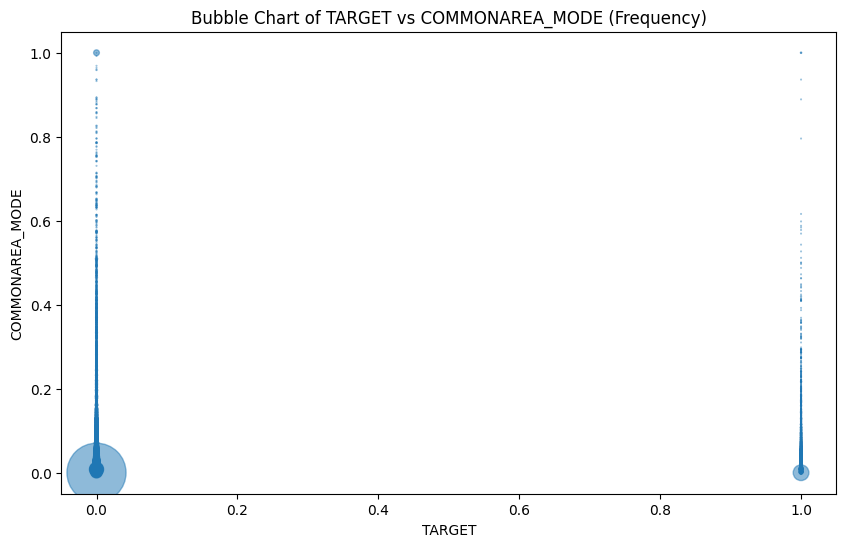

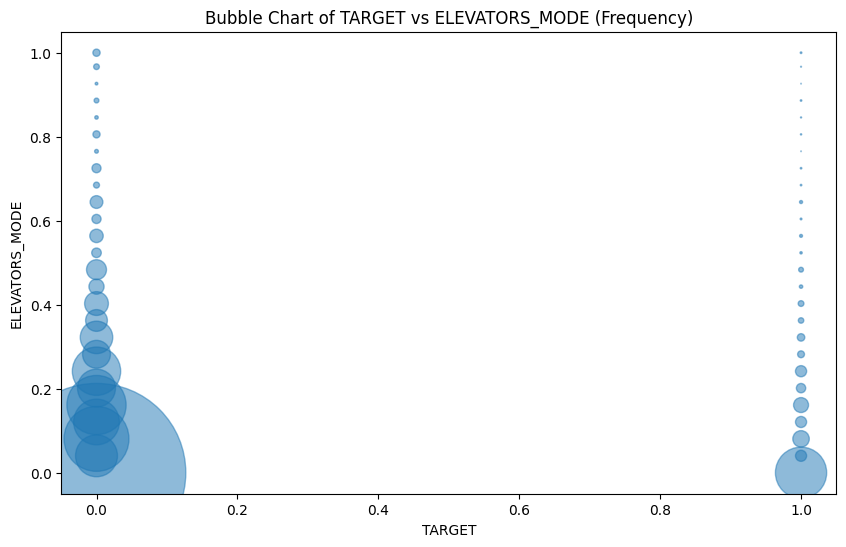

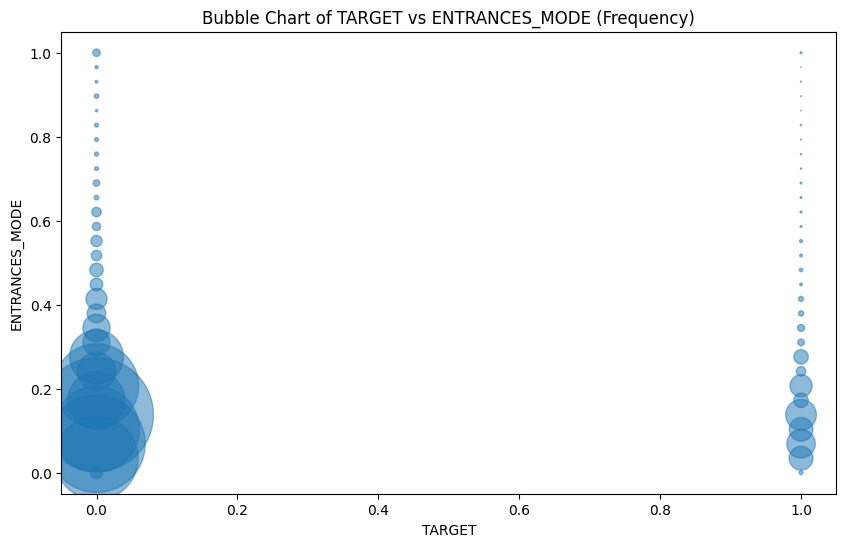

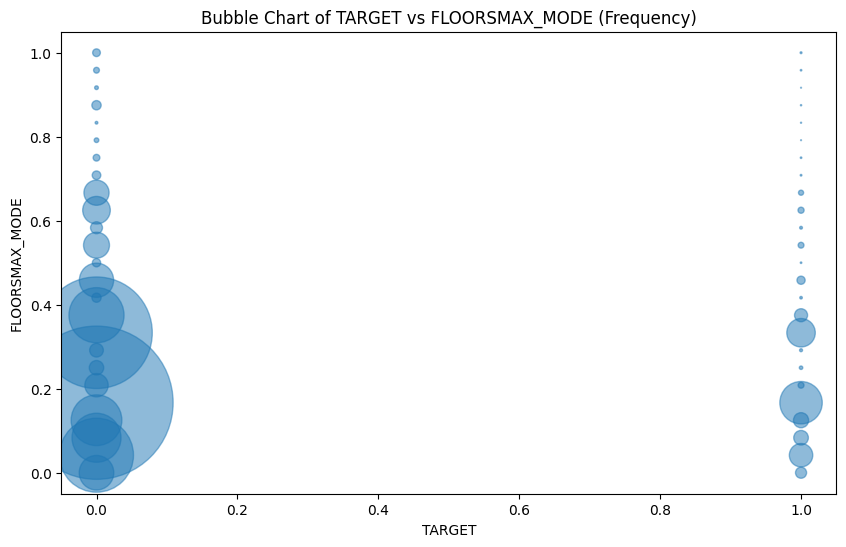

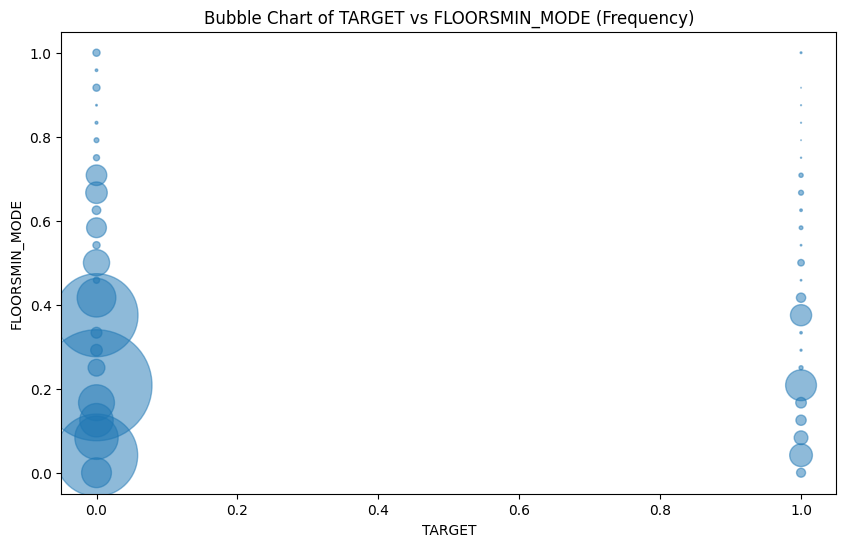

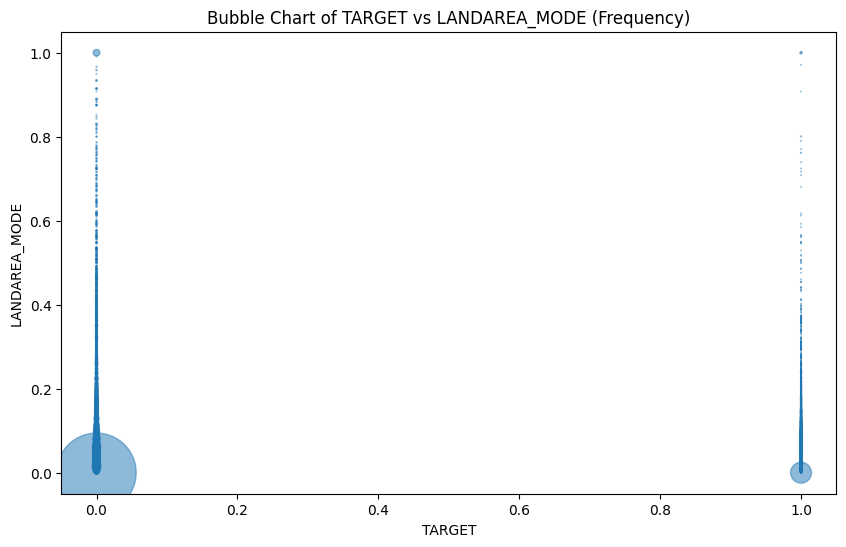

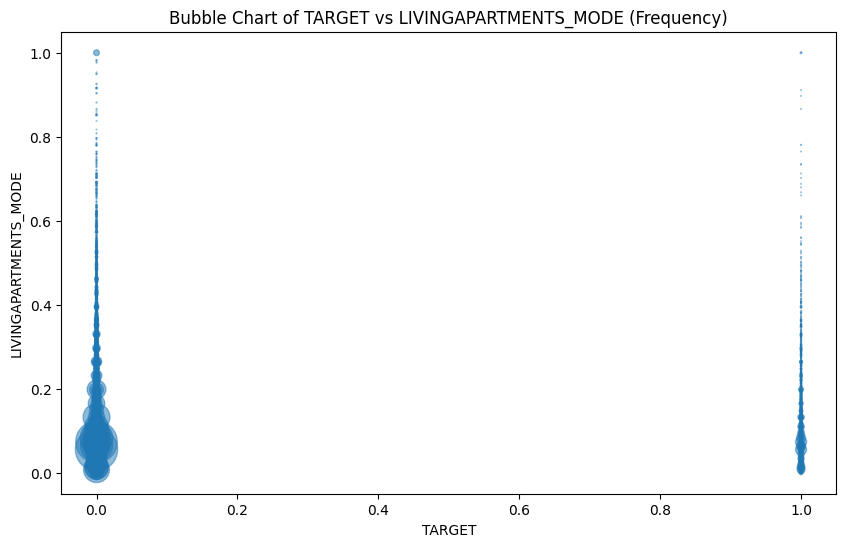

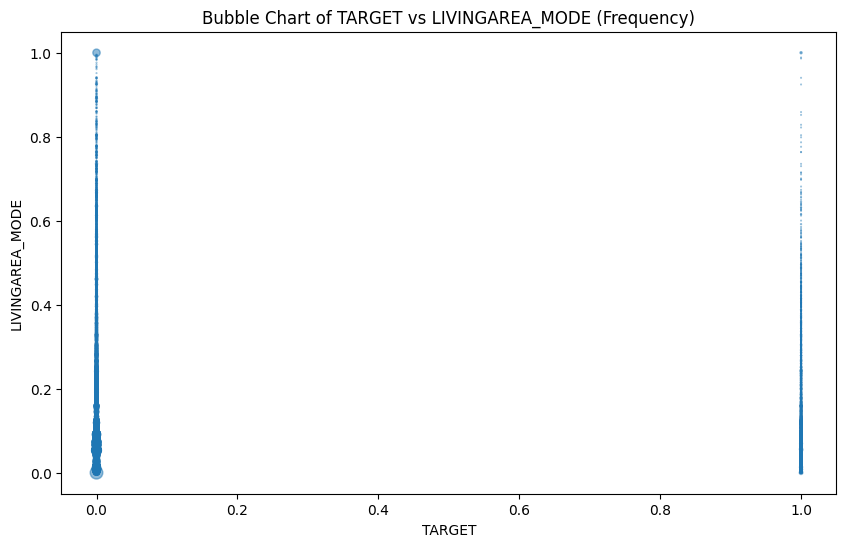

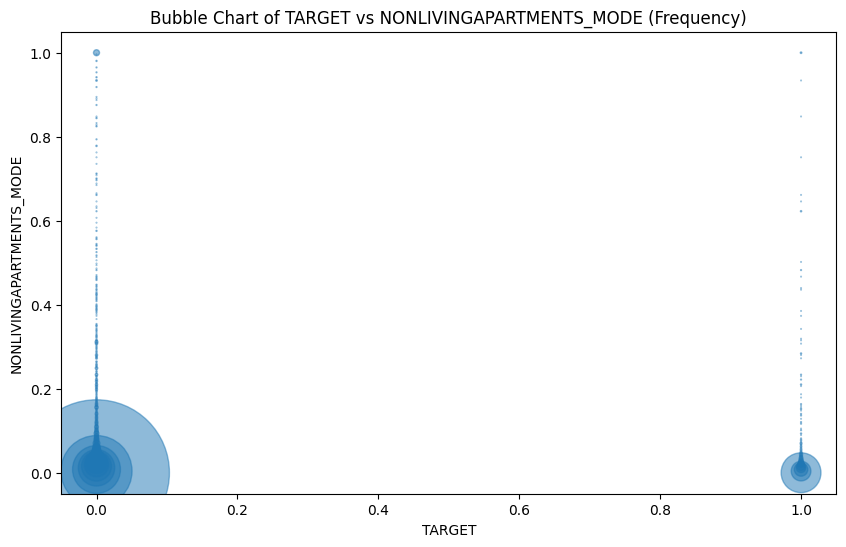

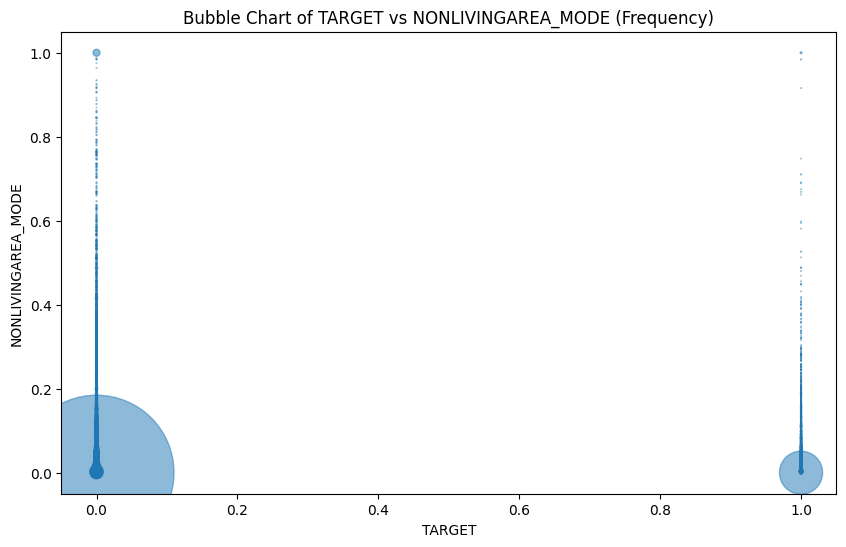

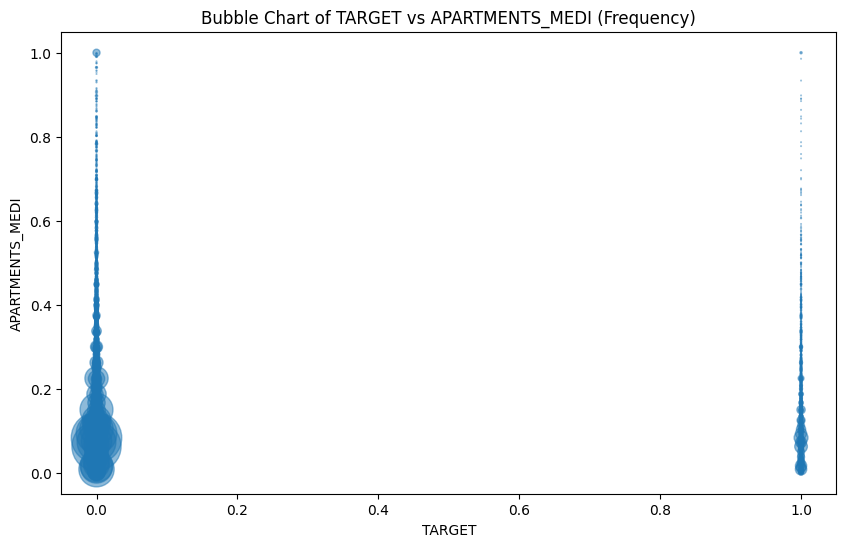

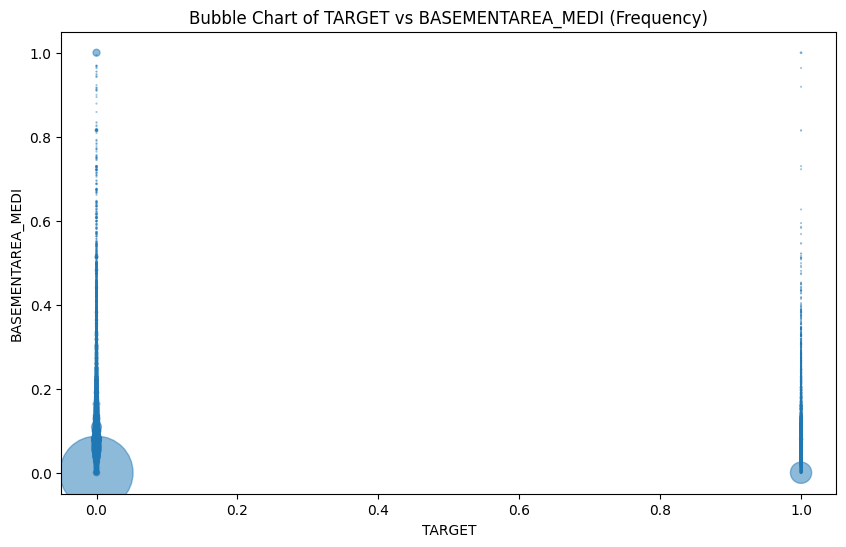

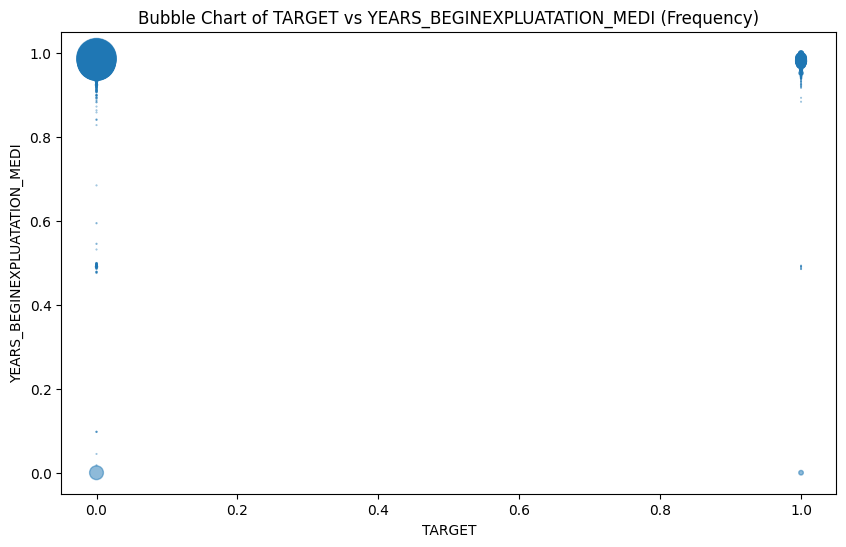

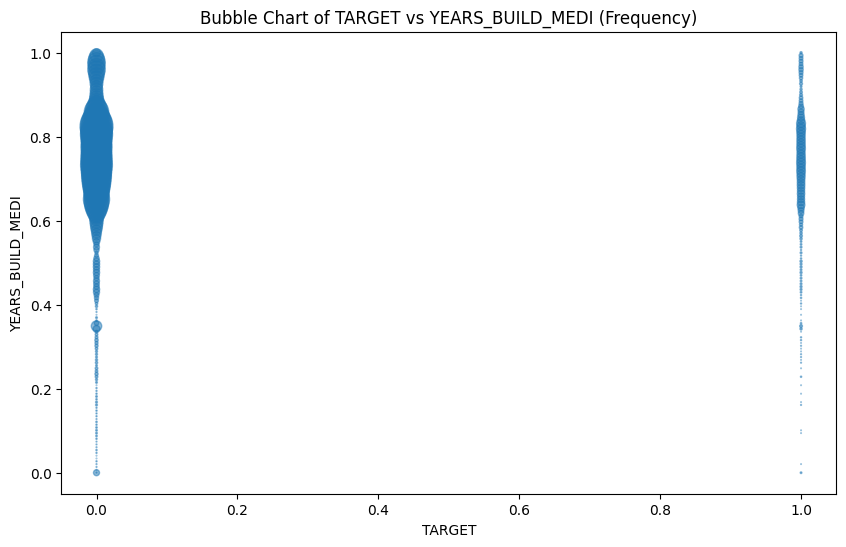

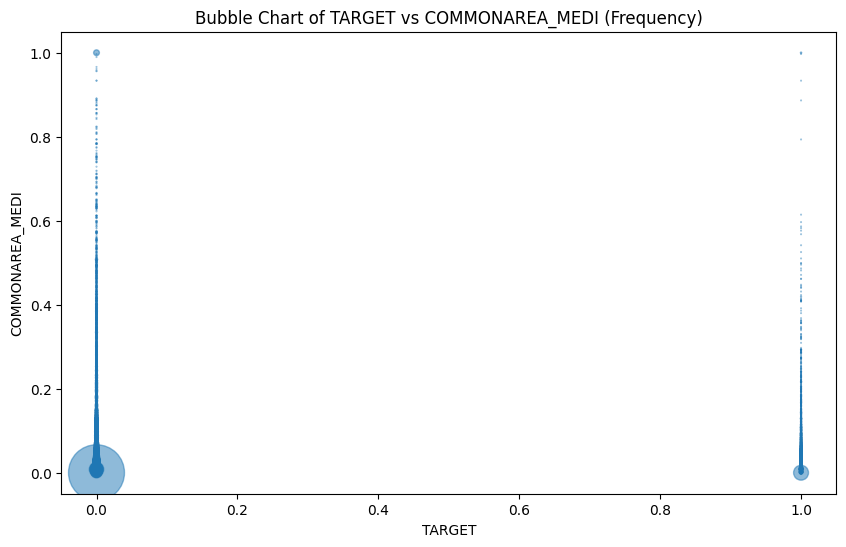

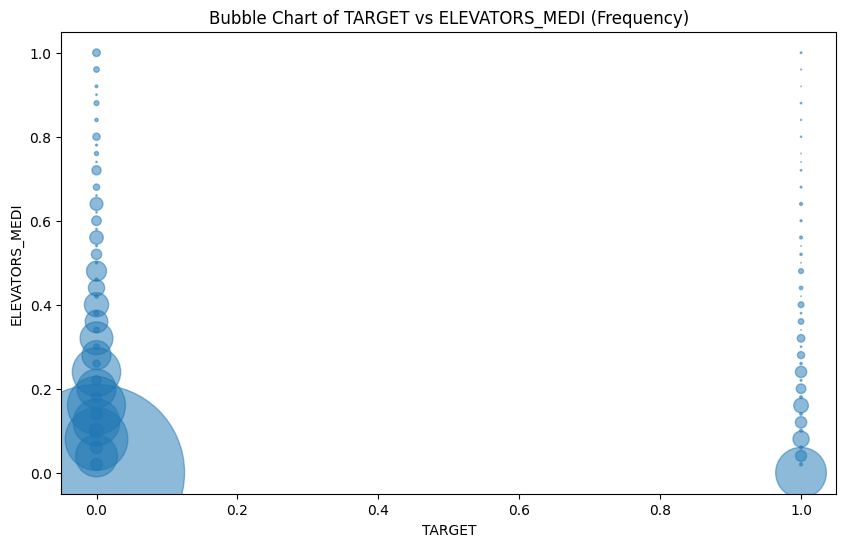

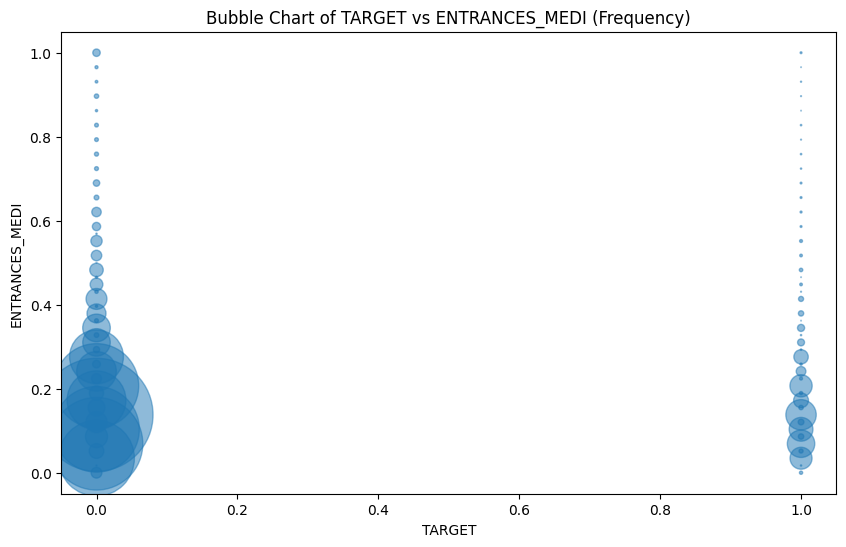

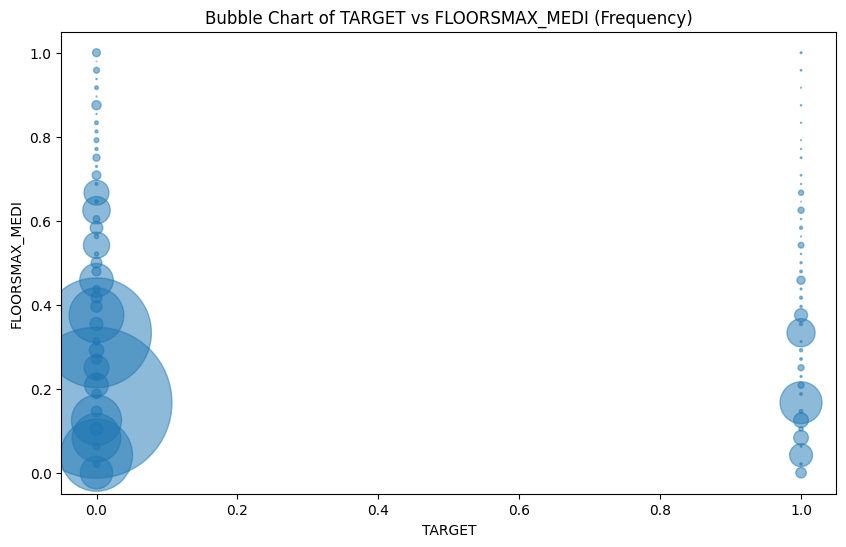

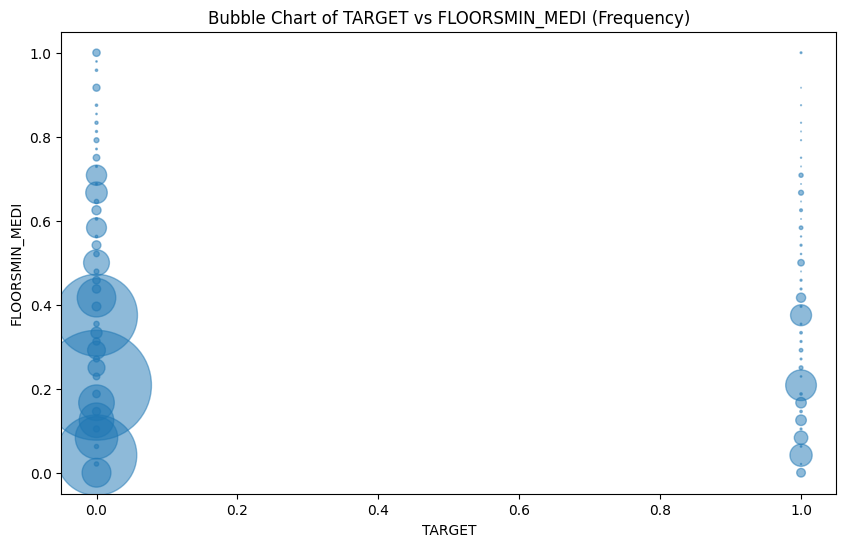

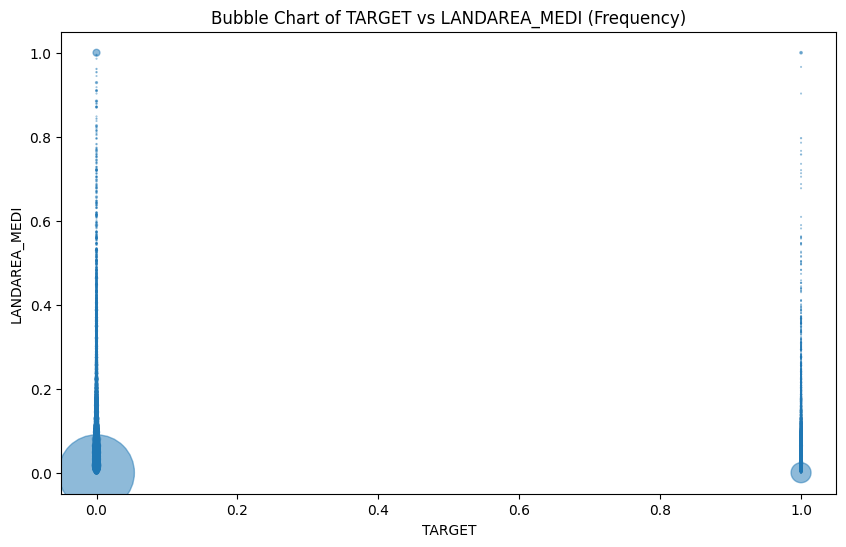

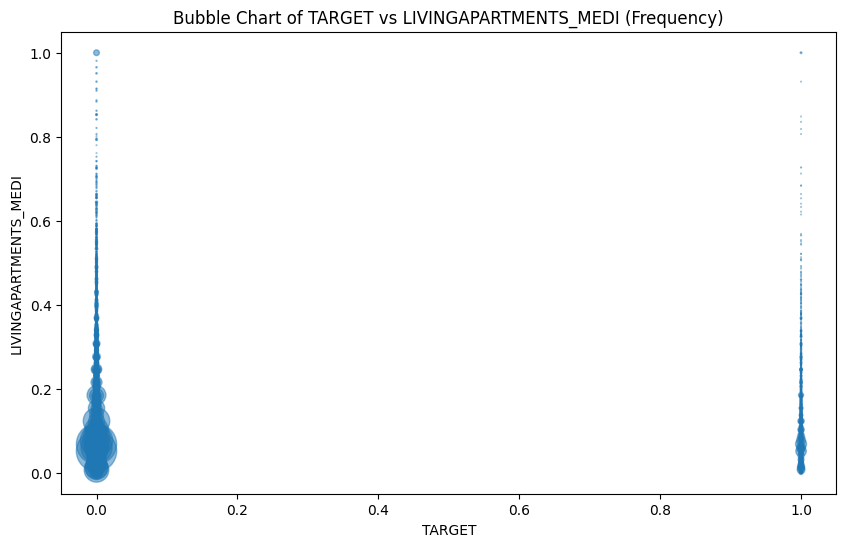

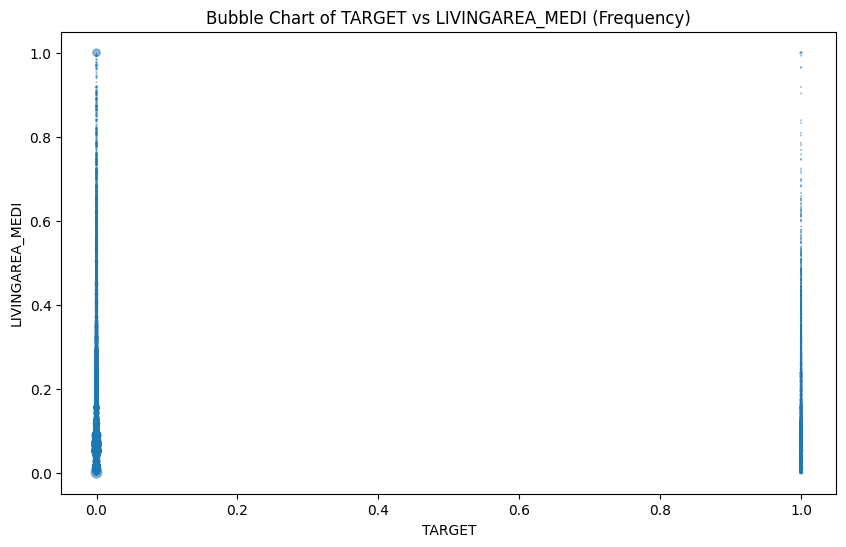

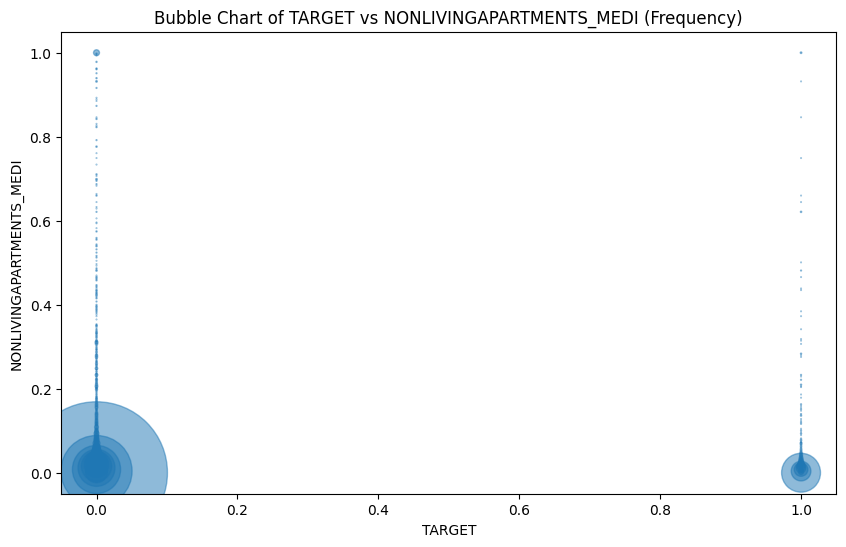

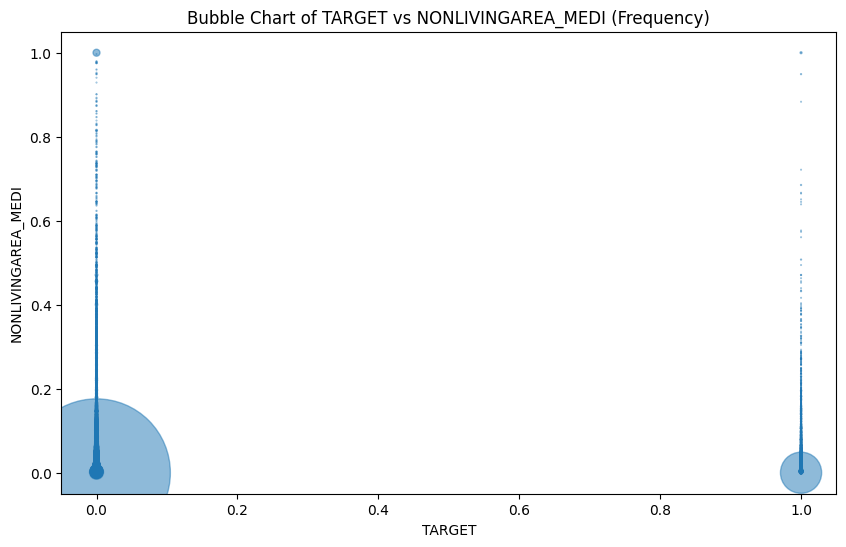

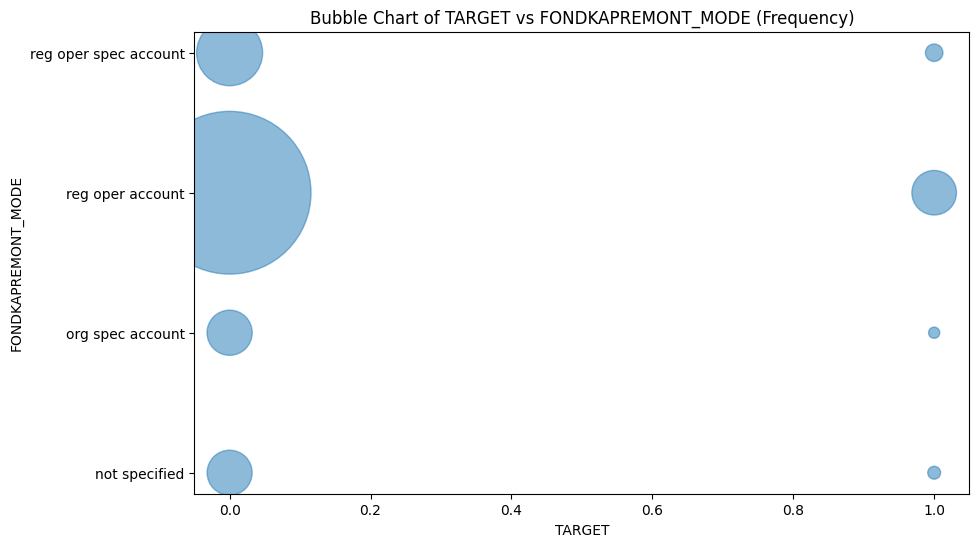

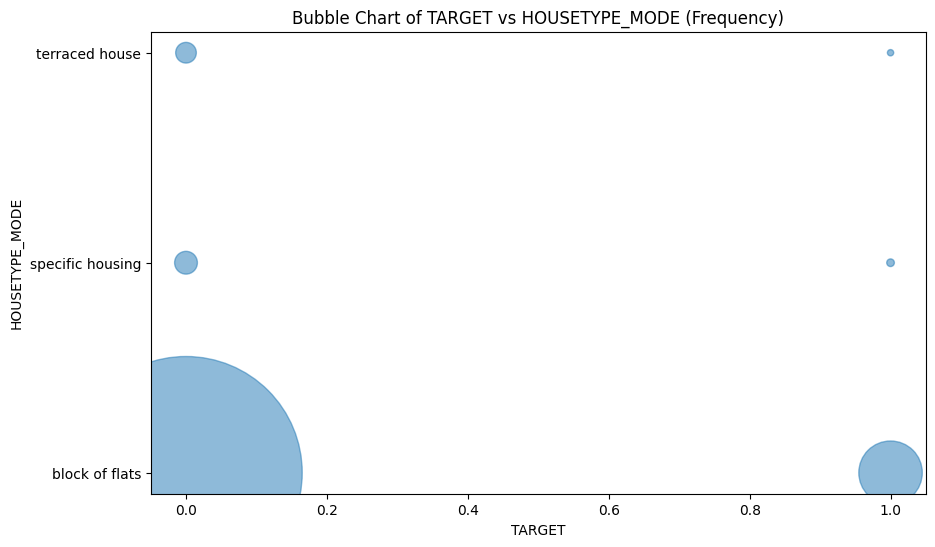

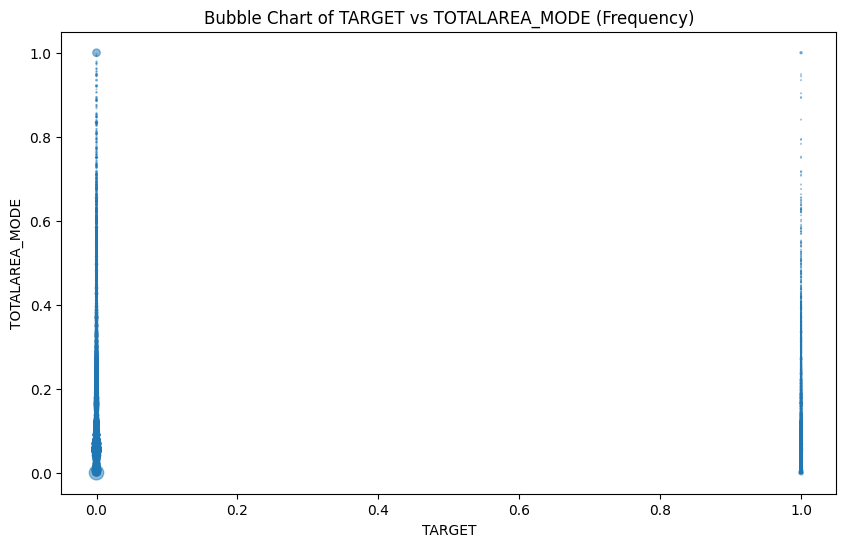

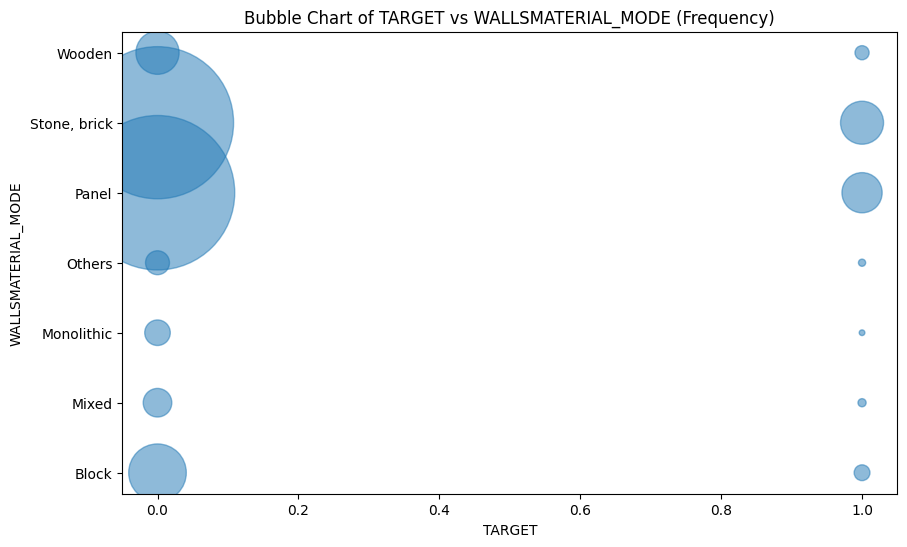

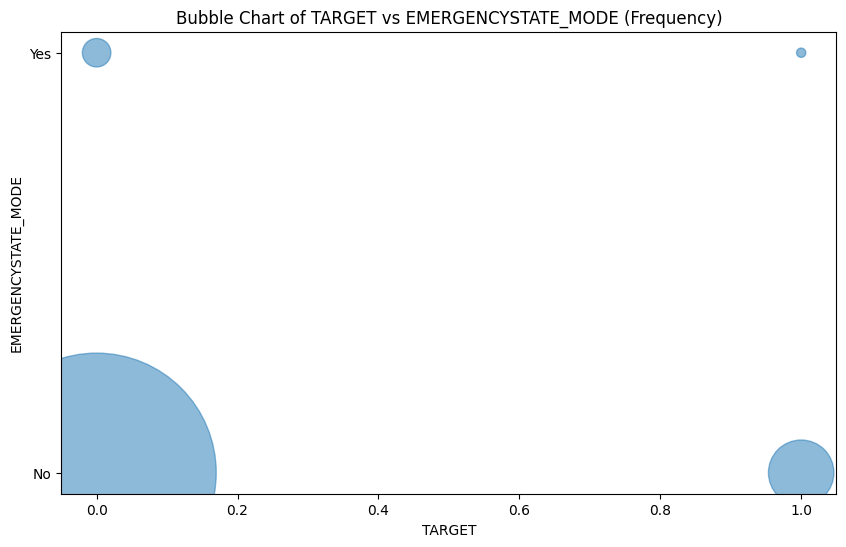

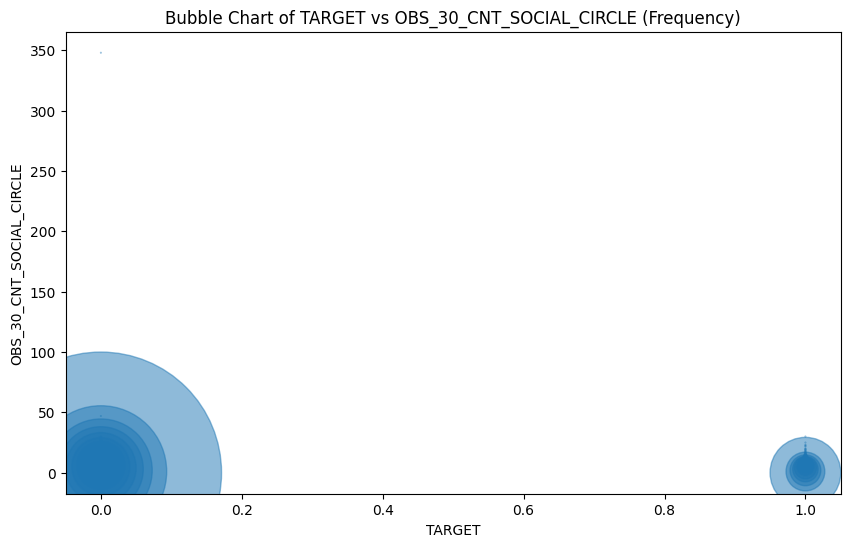

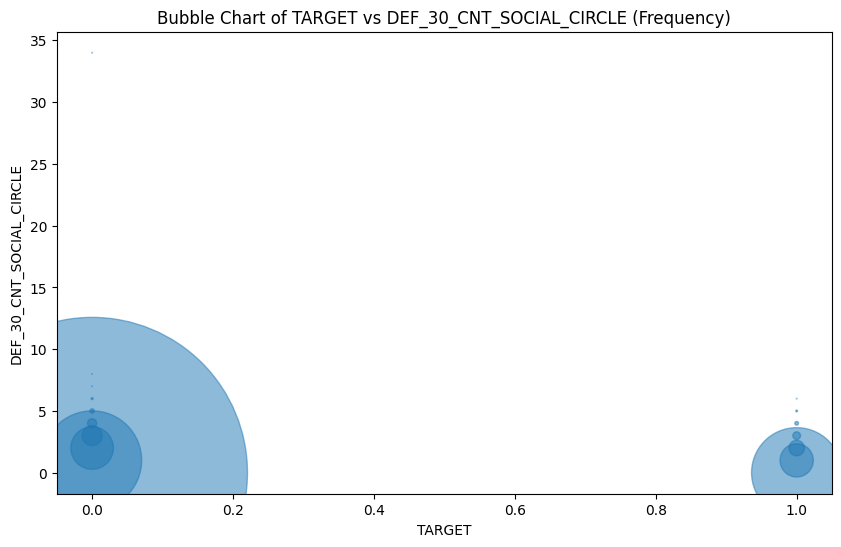

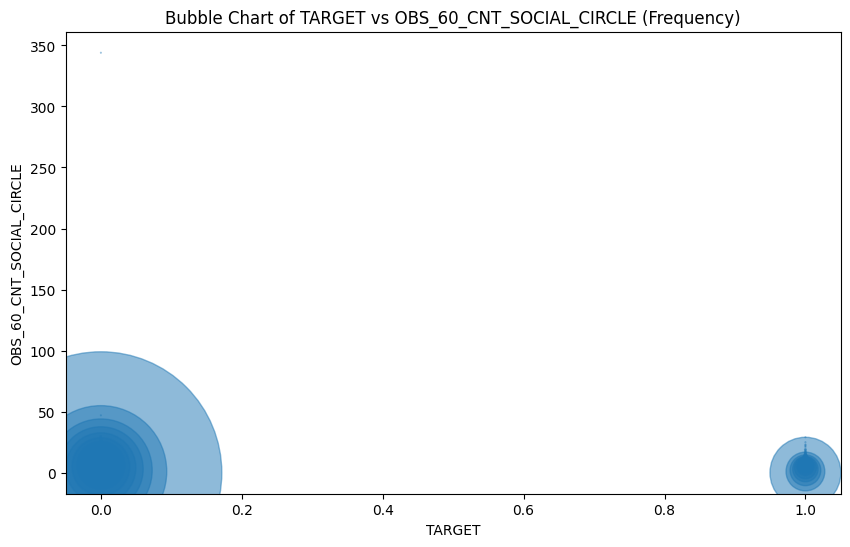

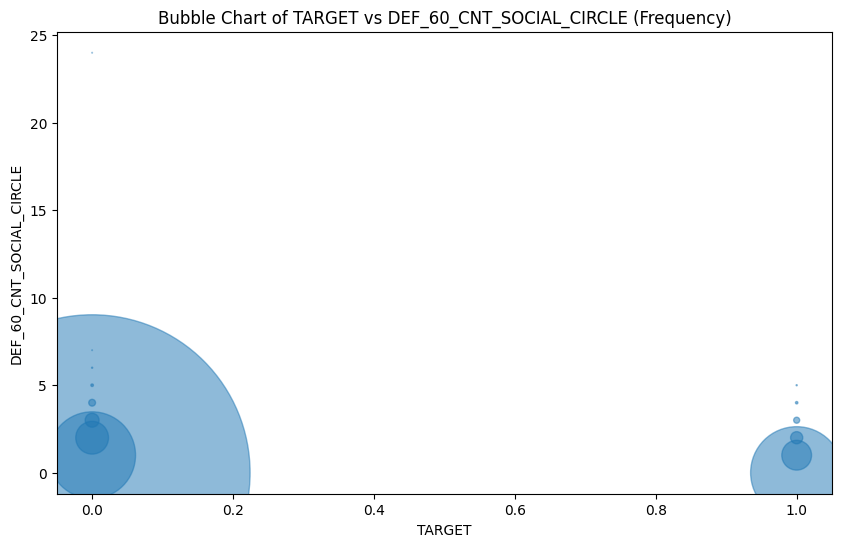

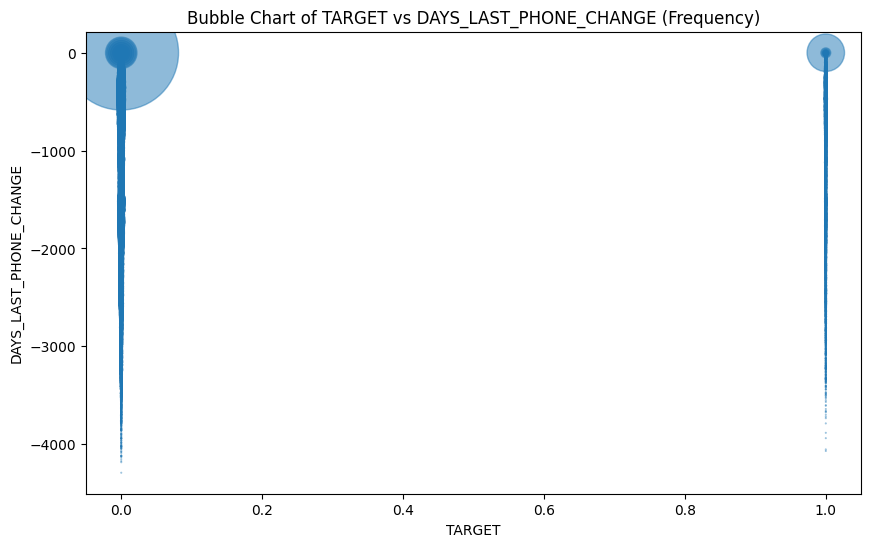

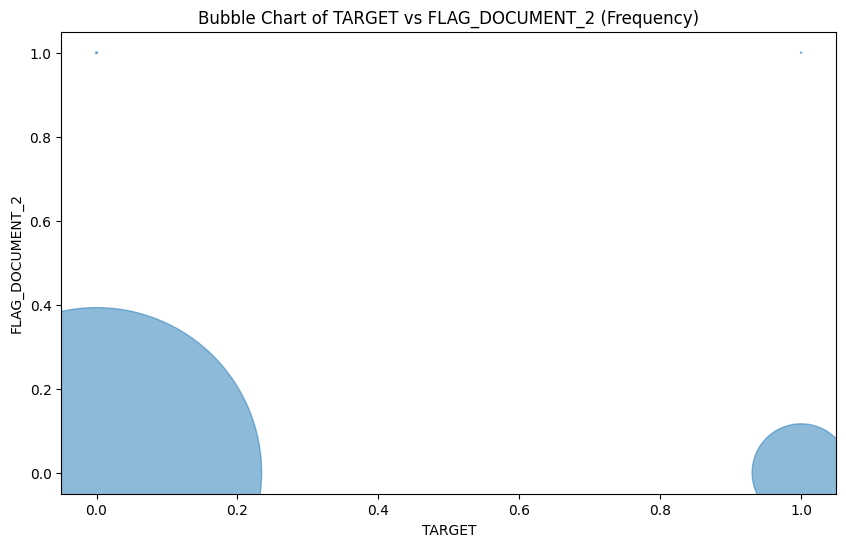

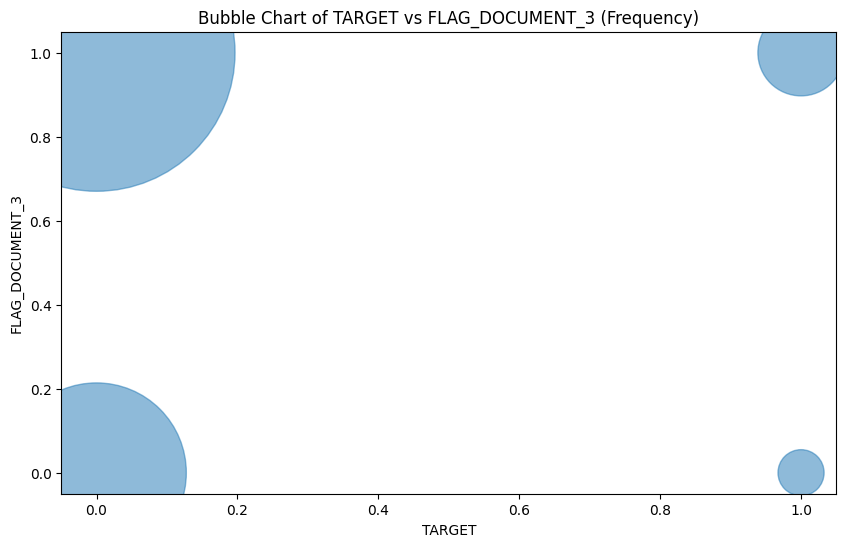

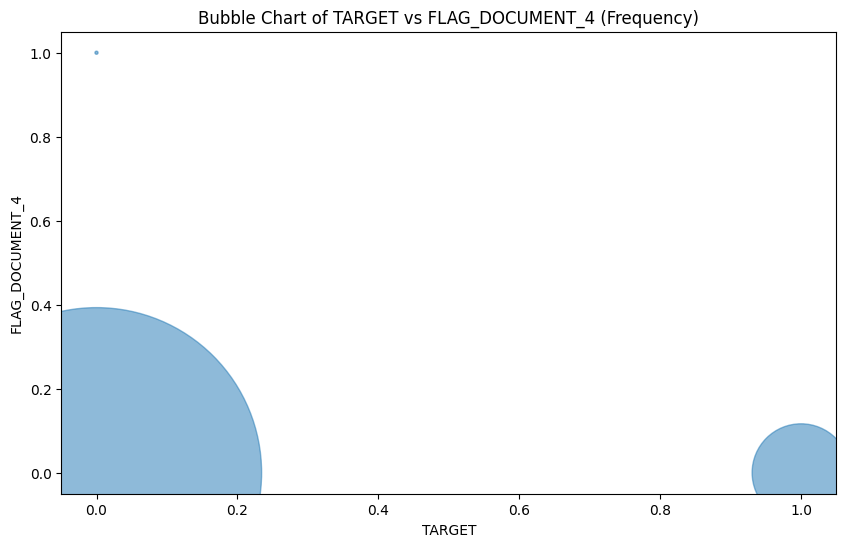

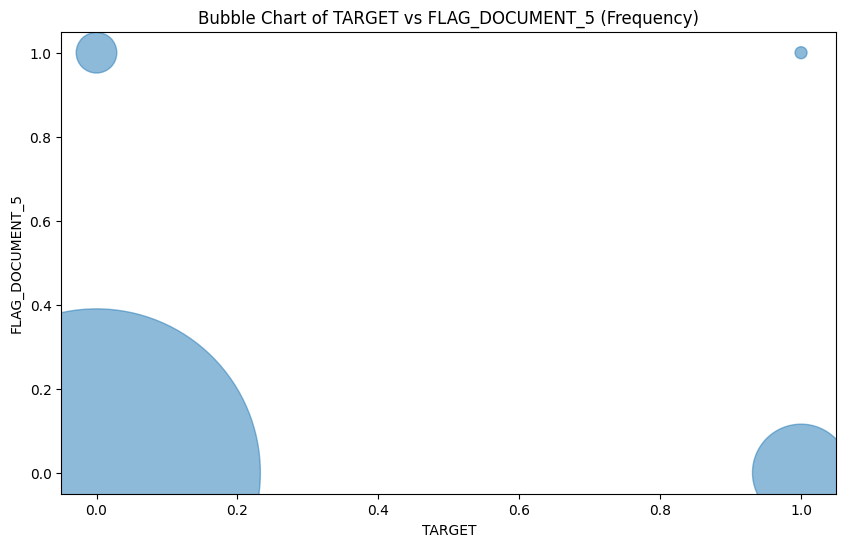

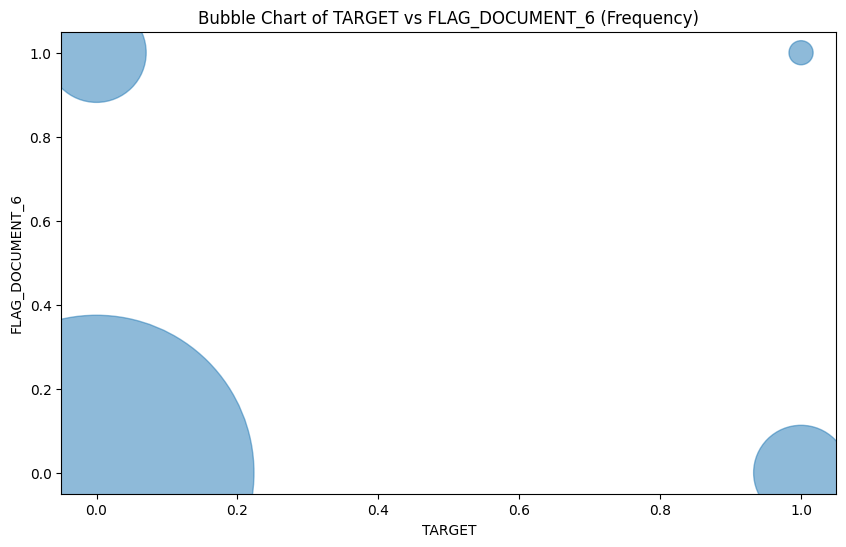

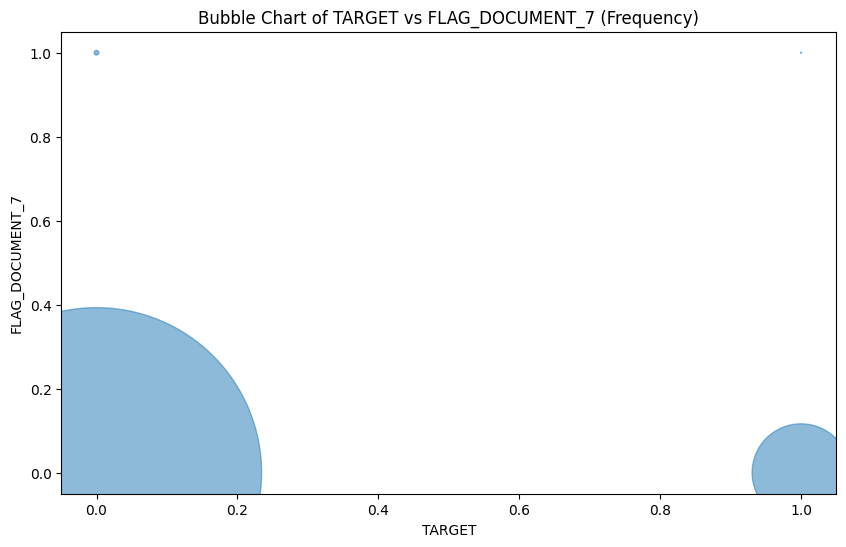

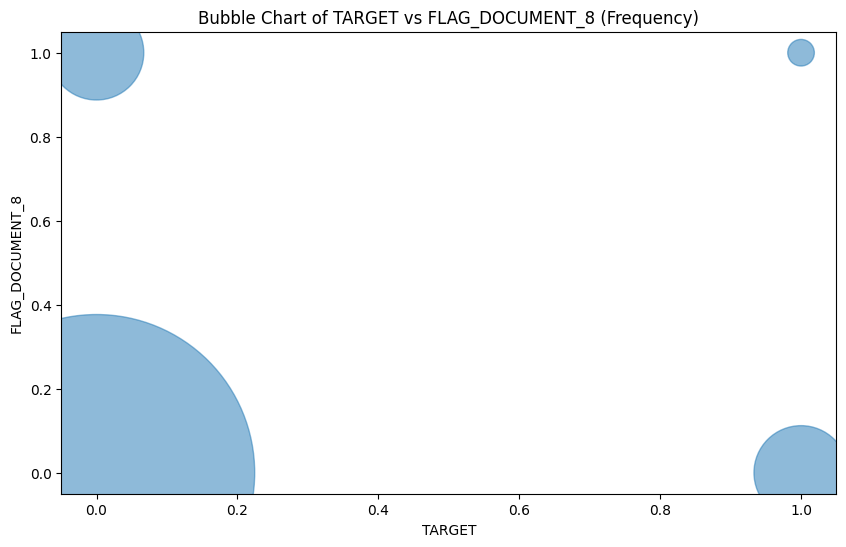

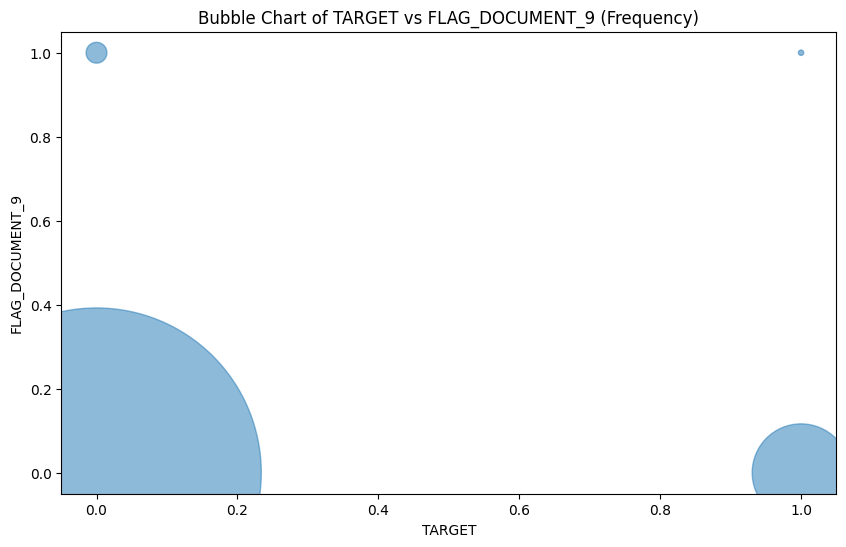

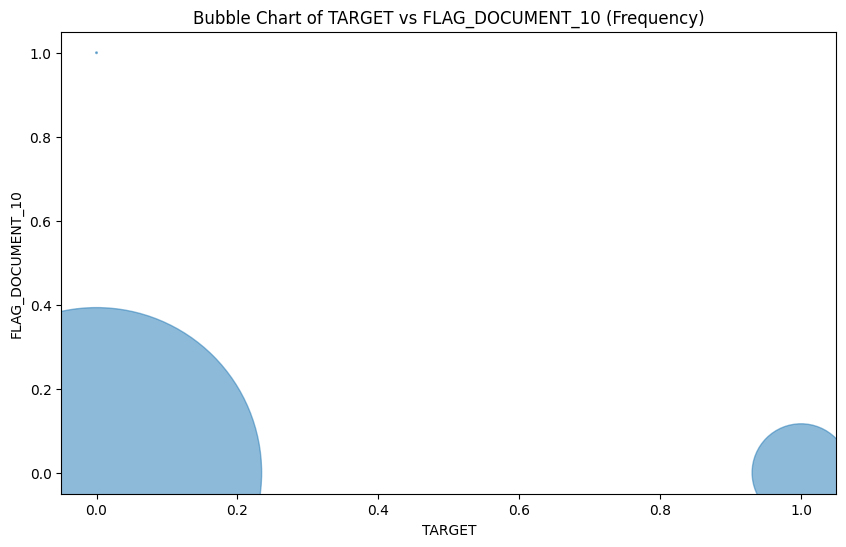

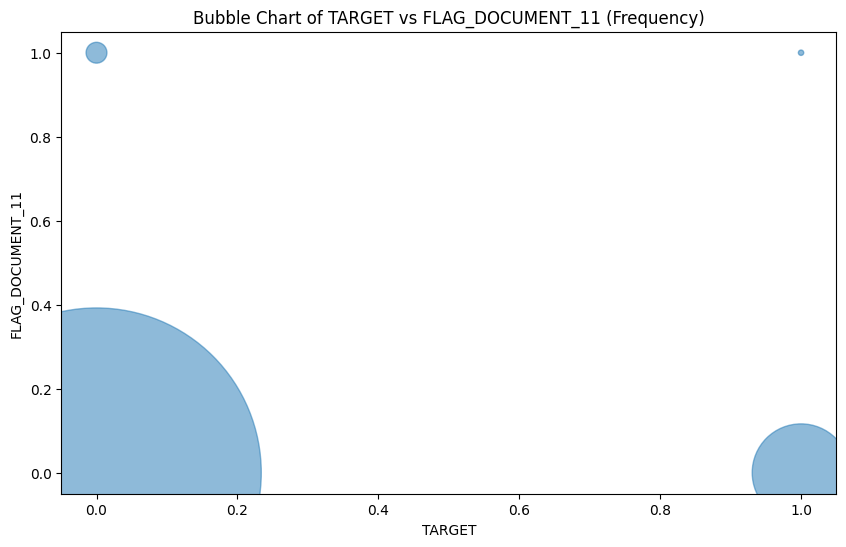

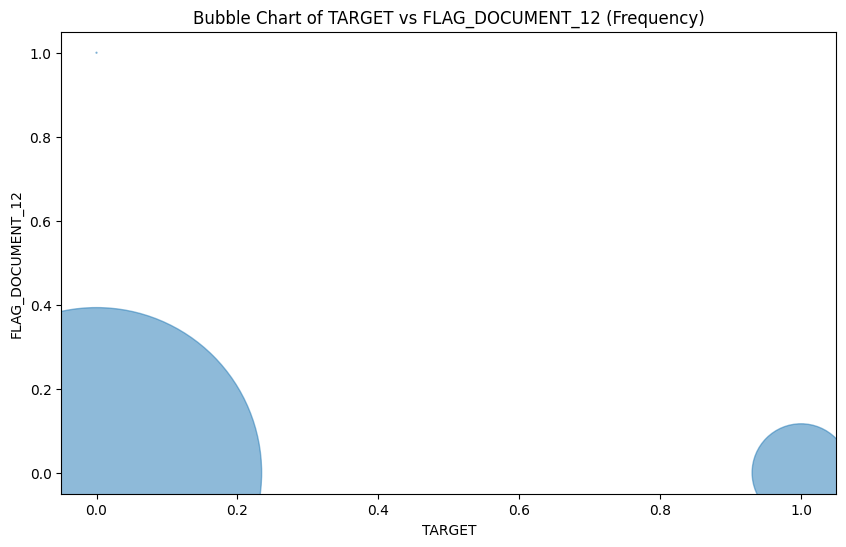

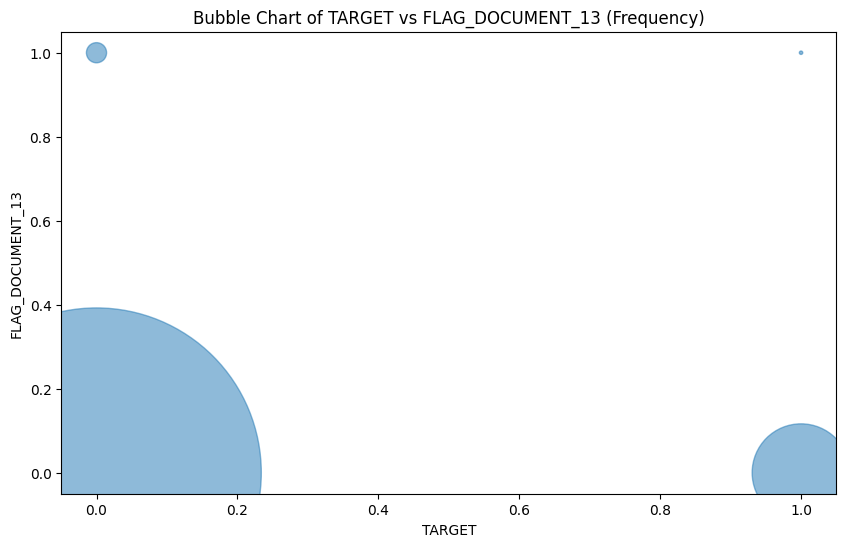

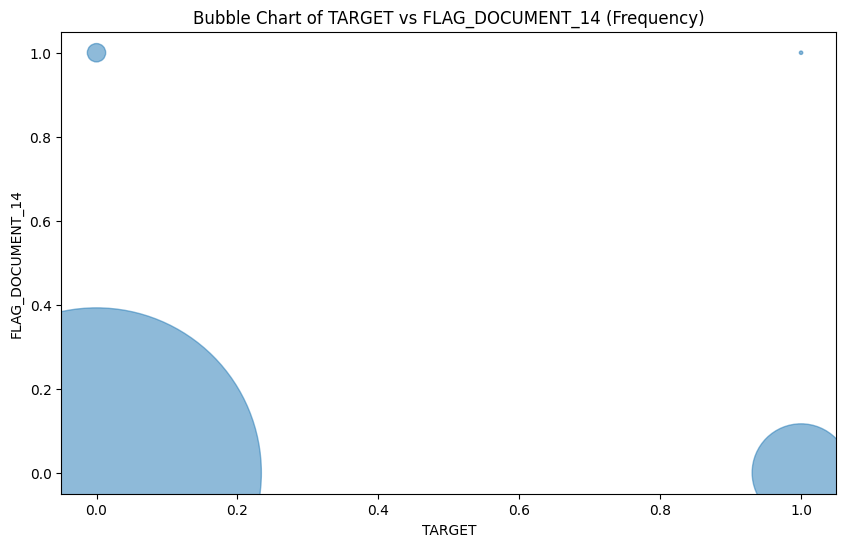

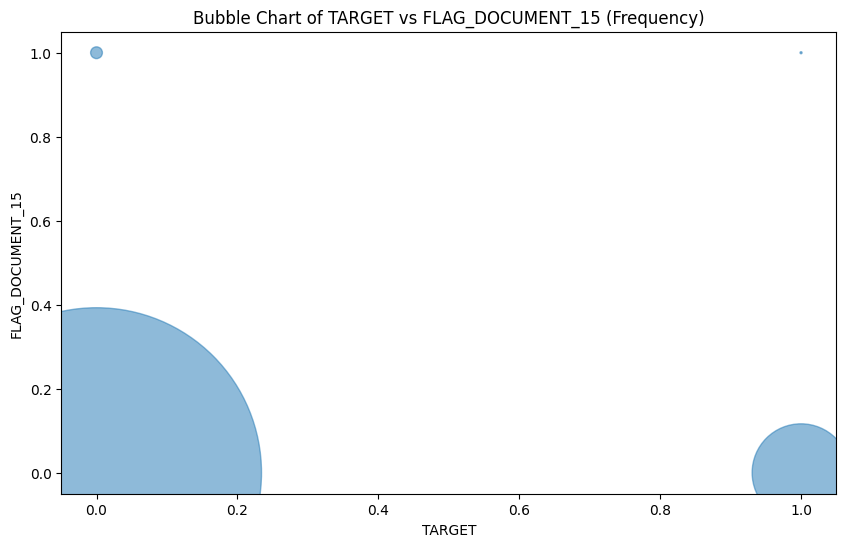

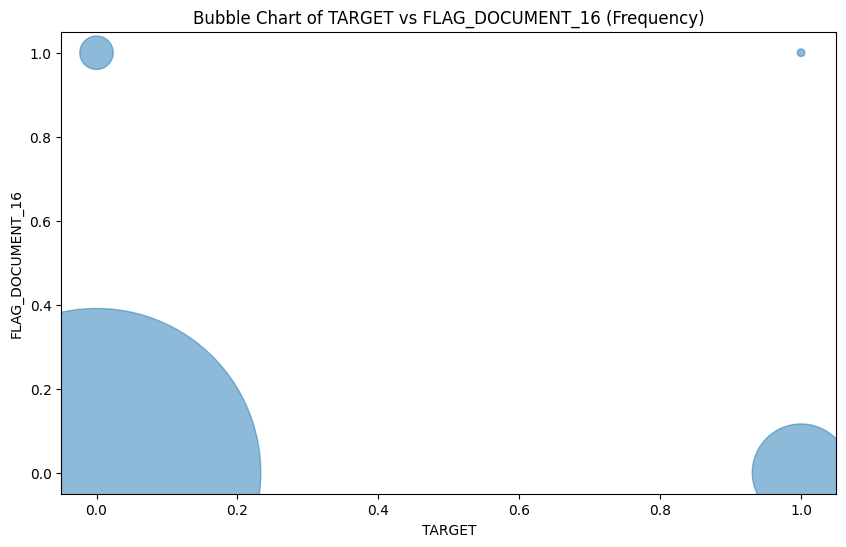

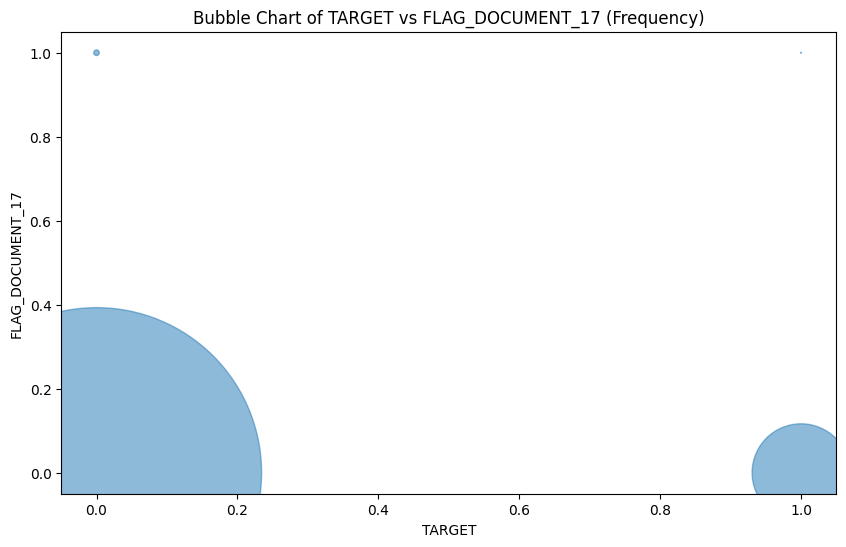

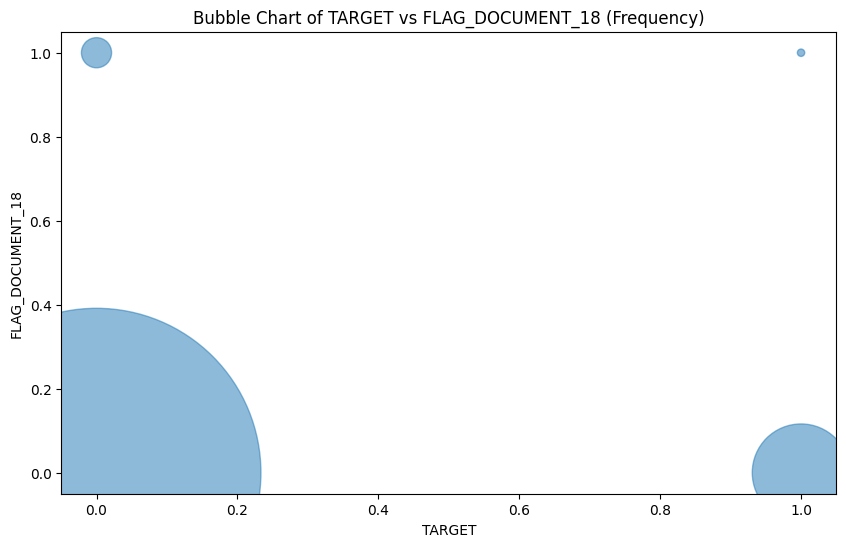

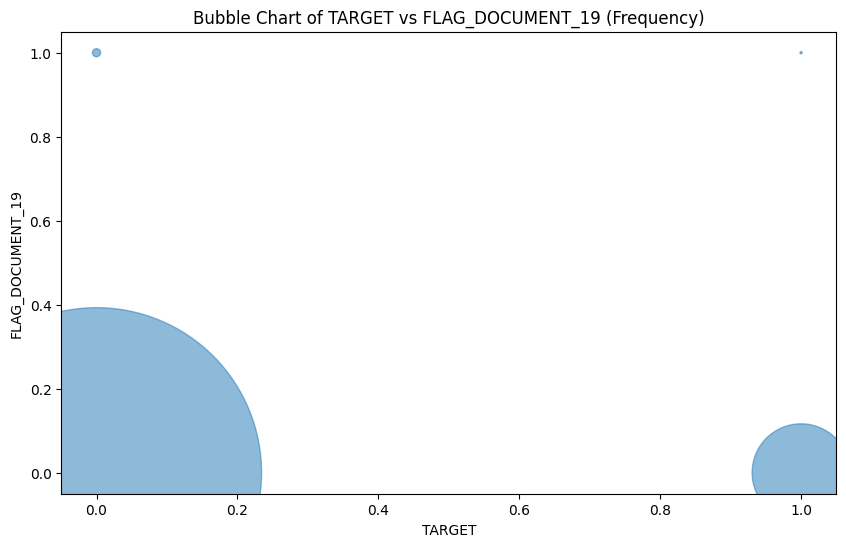

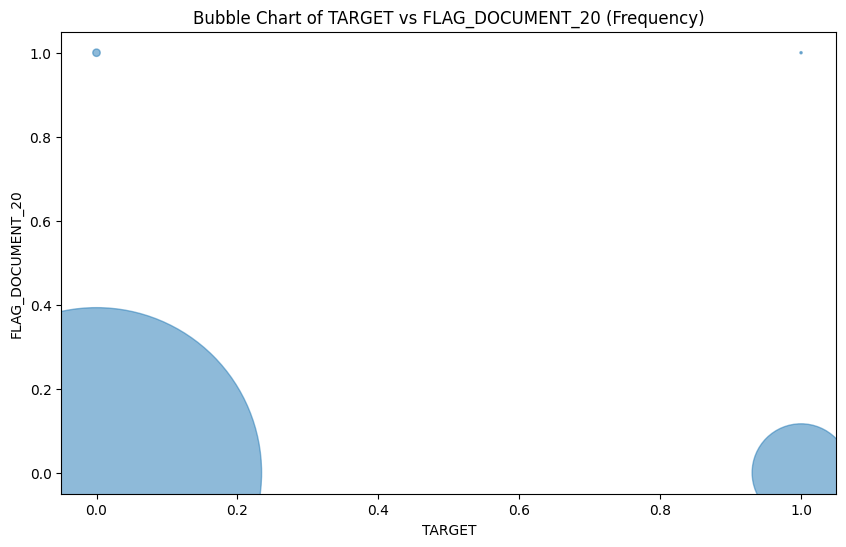

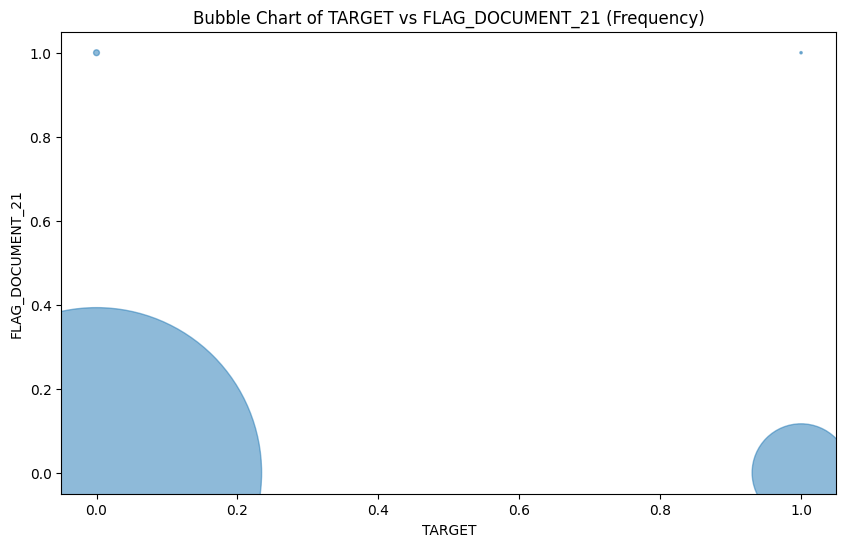

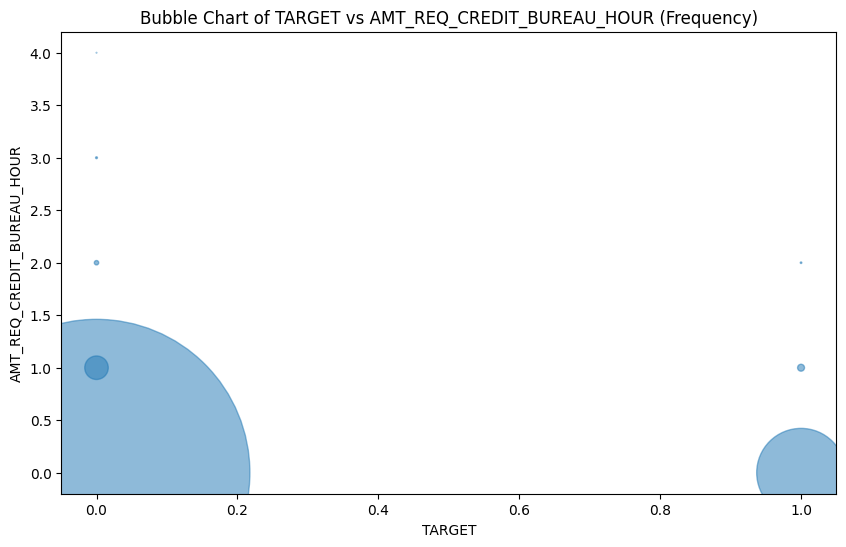

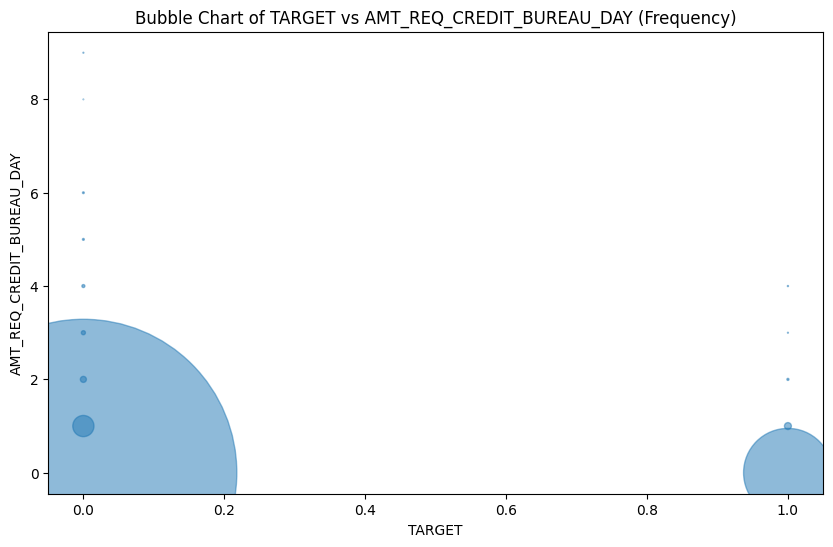

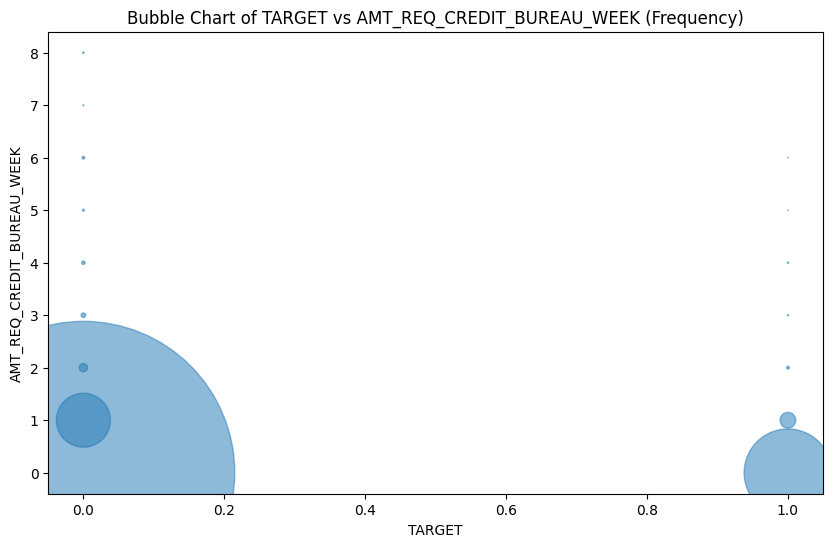

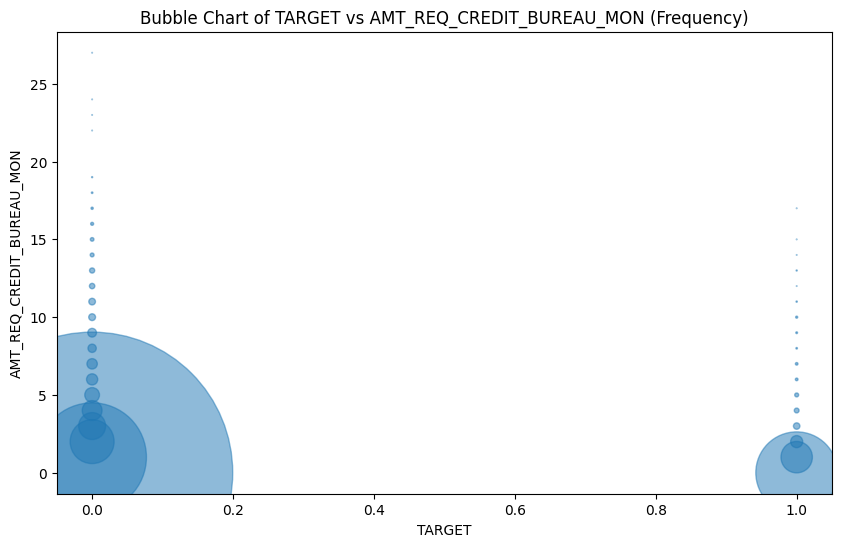

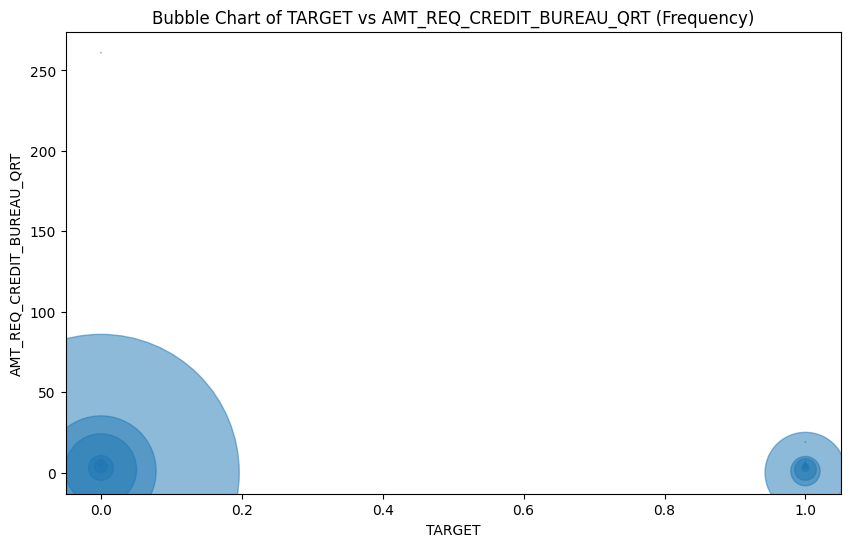

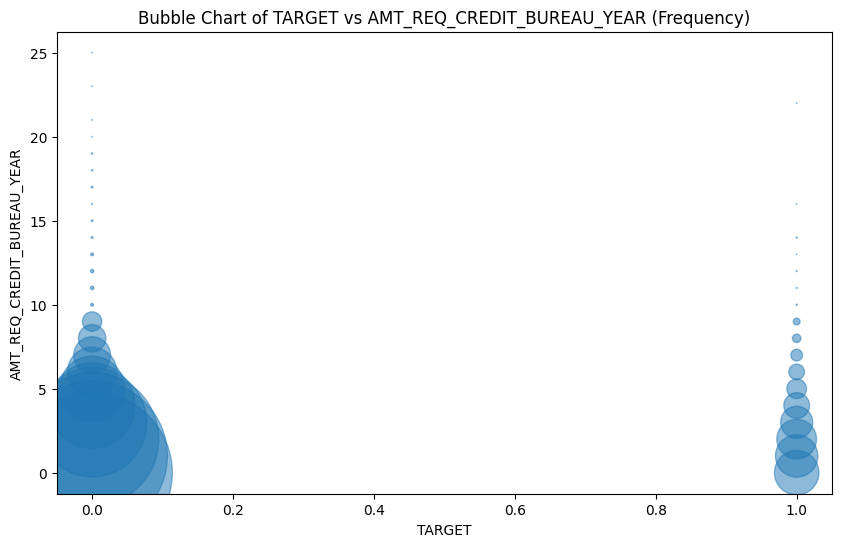

In [8]:
columns = app_data.columns.tolist()[1:]
for i in range(len(columns)):
    col = columns[i]

    bubble_data = app_data.groupby(['TARGET', col]).size().reset_index(name='Frequency')
    bubble_size = bubble_data['Frequency'] * 0.2

    plt.figure(figsize=(10, 6))
    plt.scatter(bubble_data['TARGET'], bubble_data[col], s=bubble_size, alpha=0.5)

    plt.xlabel('TARGET')
    plt.ylabel(col)
    plt.title(f'Bubble Chart of TARGET vs {col} (Frequency)')
    plt.show()

We took a look at all the columnnames and their description and found a couple that could be interesting.

1. TARGET | The target we want to guess.
2. CODE_GENDER | Maybe males are more likely to acumulate debts.
3. FLAG_OWN_REALTY | Whether or not a person owns realty might correlate with financial situation.
4. CNT_CHILDREN | Could more children equate to more debt.
5. AMT_INCOME_TOTAL | Total income has a big role in what a person is living with.
6. AMT_CREDIT | The more you loan the worse?
7. AMT_ANNUITY | The more you loan the worse but with annuity loans? 
8. NAME_EDUCATION_TYPE | Education could influence how consciously a person handles their finances.
9. NAME_FAMILY_STATUS | Marital status tells a lot about a persons costs.
10. NAME_HOUSING_TYPE | Living situation could correlate with financial situation
11. DAYS_BIRTH | The older the wiser?
12. FLAG_MOBIL | Does no phone mean no money?
13. FLAG_WORK_PHONE | The same as FLAG_MOBIL but with work
14. FLAG_CONT_MOBILE | Could evading people be having more troubles than other people?
15. REG_CITY_NOT_LIVE_CITY | Could a person have something to hide when they live somewhere else than their contact-adress city?

We decided to plot barcharts showing these features and how many percent of people that fall in a given place of the feature have money problems. For example gender, how many percent of the clients that are male also have financial problems? The more the bars differ from eachother the more usefull the feature is.

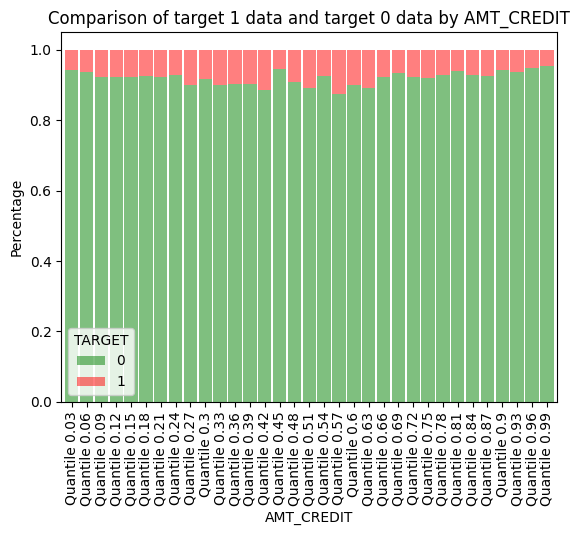

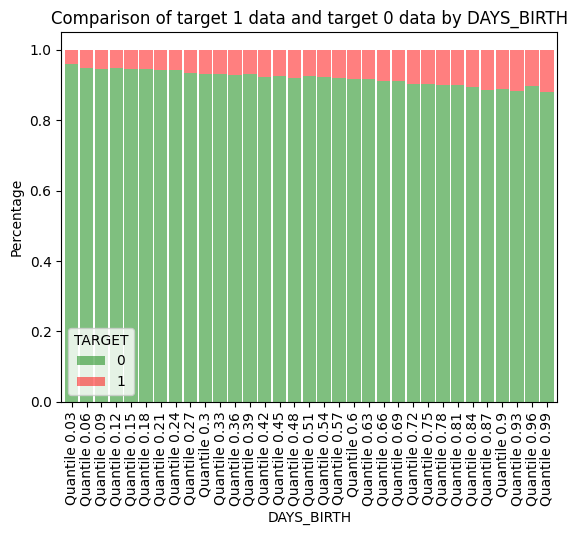

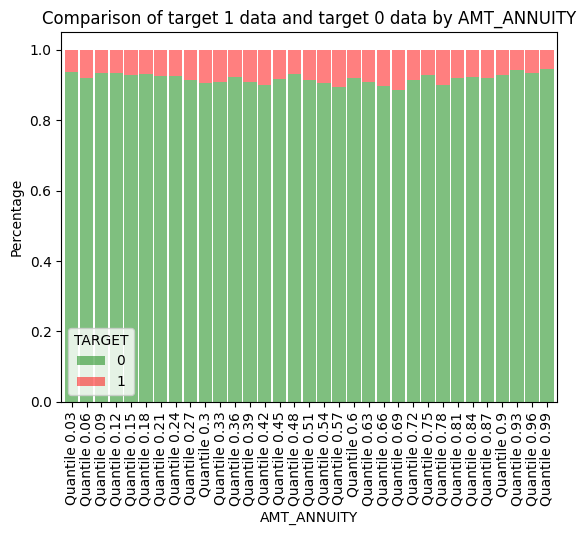

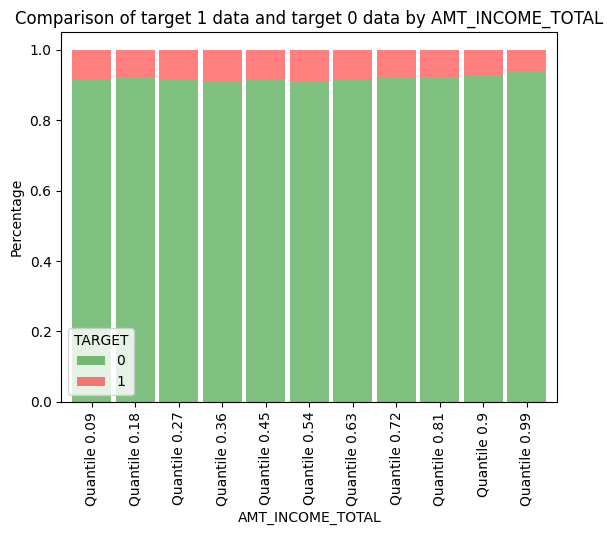

In [17]:
columns = ['AMT_CREDIT', 'DAYS_BIRTH', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL']

for col in columns:
    categorized_col = app_data
    
    bin_intervals = [3,9]
    for interval in bin_intervals:
        bins = [categorized_col[col].quantile(x/100) for x in range(0,101,interval)]
        if len(bins) == len(set(bins)):
            break

    labels = [f"Quantile {x/100}" for x in range(0,101,interval)][1:]

    categorized_col[f'{col} range'] = pd.cut(app_data[col], bins=bins, labels=labels)

    col_counts = app_data.groupby(f'{col} range', observed=False)['TARGET'].value_counts(normalize=True).unstack()
    col_counts.plot(kind='bar', stacked=True, color=['green', 'red'], alpha=0.5, width=0.9)

    plt.title(f"Comparison of target 1 data and target 0 data by {col}")
    plt.xlabel(col)
    plt.ylabel("Percentage")
    plt.show()

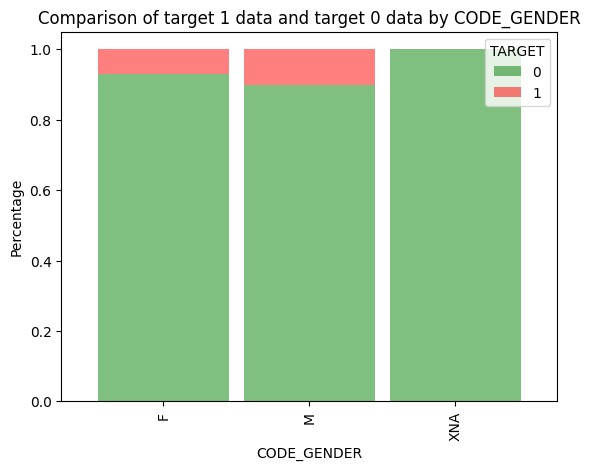

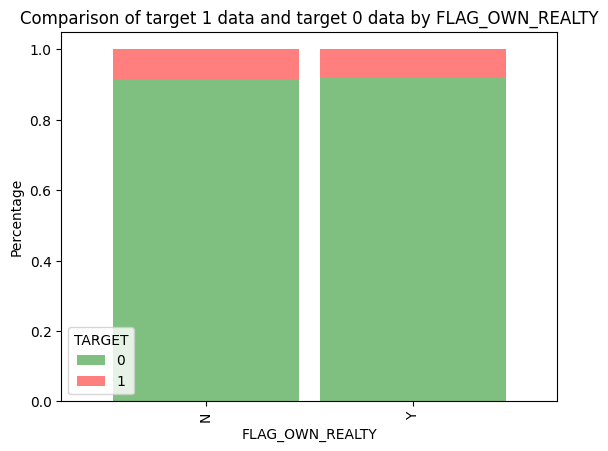

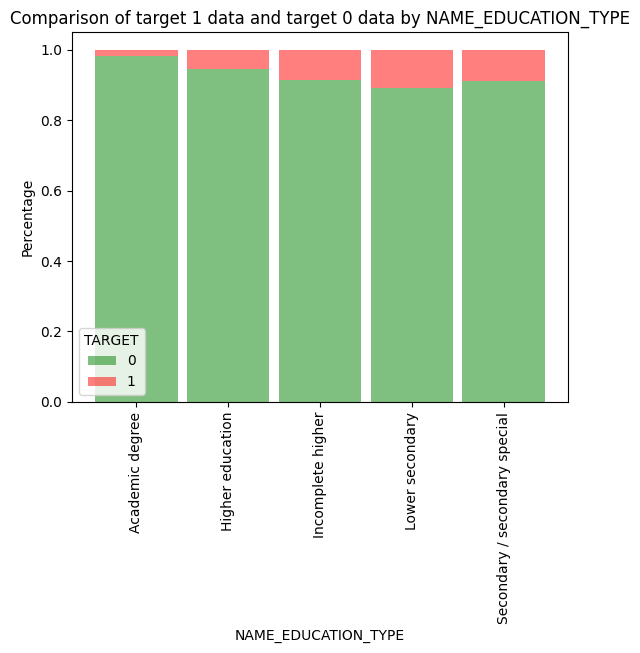

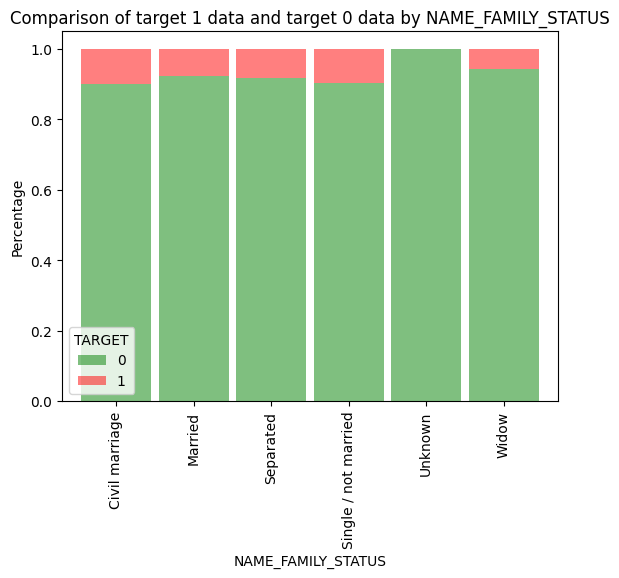

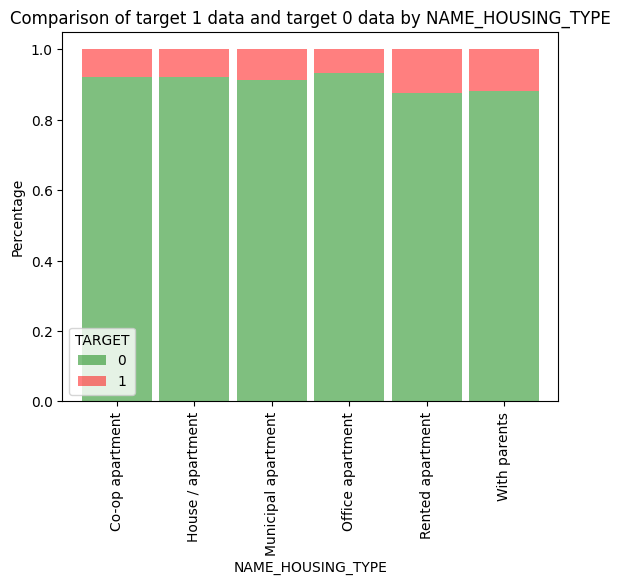

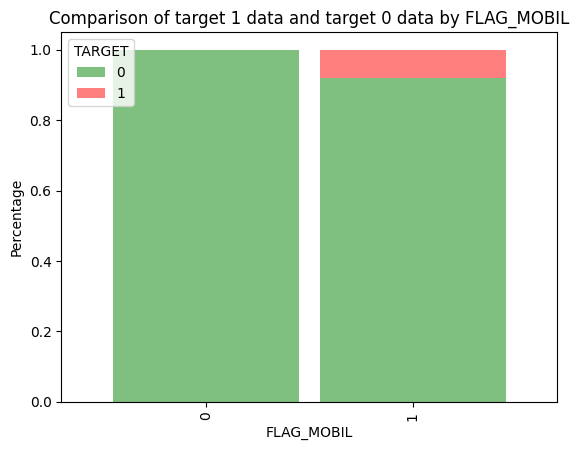

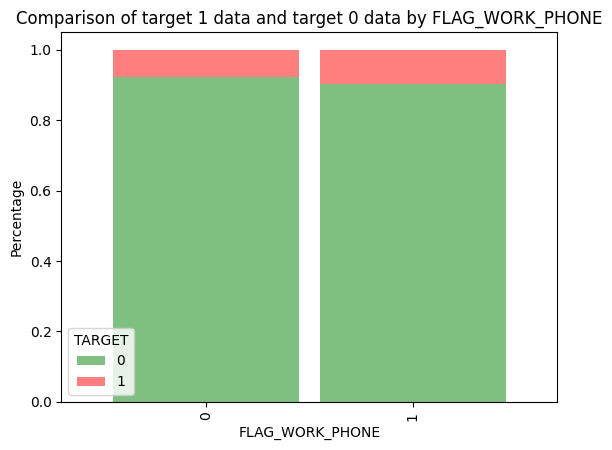

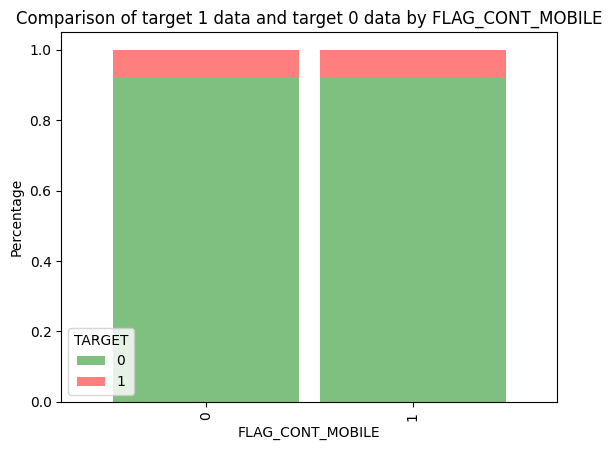

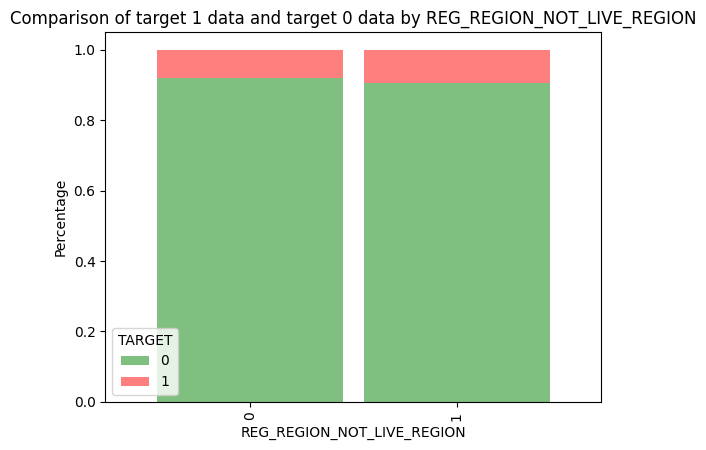

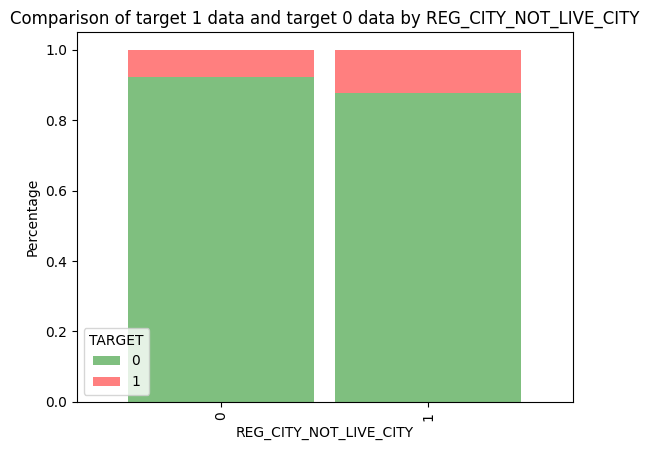

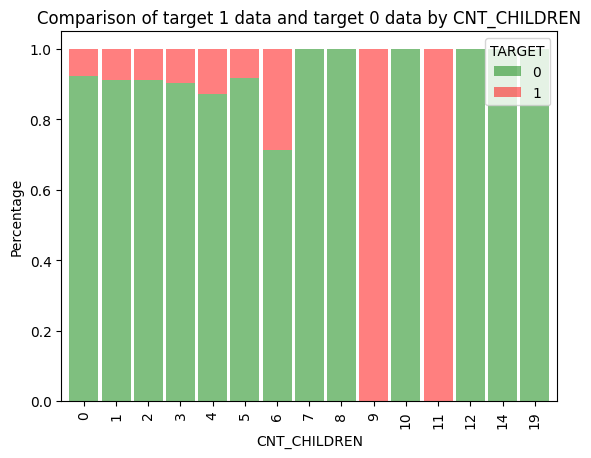

In [14]:
columns = ['CODE_GENDER', 'FLAG_OWN_REALTY', 
           'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 
           'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 
           'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
           'REG_REGION_NOT_LIVE_REGION', 'REG_CITY_NOT_LIVE_CITY',
           'CNT_CHILDREN']

for col in columns:
    gender_counts = app_data.groupby(col)['TARGET'].value_counts(normalize=True).unstack()
    gender_counts.plot(kind='bar', stacked=True, color=['green', 'red'], alpha=0.5, width=0.9)

    plt.title(f"Comparison of target 1 data and target 0 data by {col}")
    plt.xlabel(col)
    plt.ylabel("Percentage")
    plt.show()

## Chosen features
With the data visualisations given above we chose to use the features NAME_EDUCATION_TYPE, AMT_CREDIT and DAYS_BIRTH, we chose te use 3 for our first model so we could keep it simple, this will help us with evaluating if these features are actually usefull and if the addition of a 4th really helps.

## Baseline model
Lets set up a baseline to veriffy if our models will actually help with predicting if a client will have banking problems

In [7]:
target_count = app_data['TARGET'].value_counts()
baseprob = target_count[0]/(target_count[0] + target_count[1])*100
baseprob

91.92711805431351

Here we can see that 91.93% of people do not have banking problems, we can use this to determine if we created a good model. If our model has a worse accuracy than 91.93% then we know it is a bad model.